In [1]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import pyclesperanto_prototype as cle
cle.select_device('RTX')
print("Using OpenCL device " + cle.get_device().name)

import math
import numpy as np
import pandas as pd
import cv2
import tifffile
import os
import sys
import nrrd
import cupy as cp
from cupyimg.scipy.ndimage.morphology import binary_hit_or_miss
from tqdm import tqdm
import itertools

sys.path.append("C:/Users/danie/BoneSegmentation")
from oiffile import OifFile
from src.OifImageViewer import OifImageViewer
from src.kernels import get_unique_kernels, load_from_cache

Using OpenCL device NVIDIA GeForce RTX 2080 Ti


In [2]:
# path = "/home/dkermany/data/Bone_Project/weijie_selected/main_folder/FV10__oibs/FV10__20190620_111343.oib"
path = "D:/Datasets/Bone_Mets/FV10__oibs/FV10__20190620_111343.oib"
filename = os.path.splitext(os.path.basename(path))[0]

with OifFile(path) as oif:
    viewer = OifImageViewer(oif)
    x_step, y_step, z_step = map(float, (viewer.md["x_step"], viewer.md["y_step"], viewer.md["z_step"]))
    if viewer.md["z_unit"] == "nm":
        z_step /= 1000.

Image shape: (3, 76, 2404, 3376)
Axes: CZYX
Dtype: uint16
Intervals: X (1.242um) Y (1.242um) Z (2660.0nm)



Load 3D Masks
----------------------

(228, 2404, 3376)
uint16


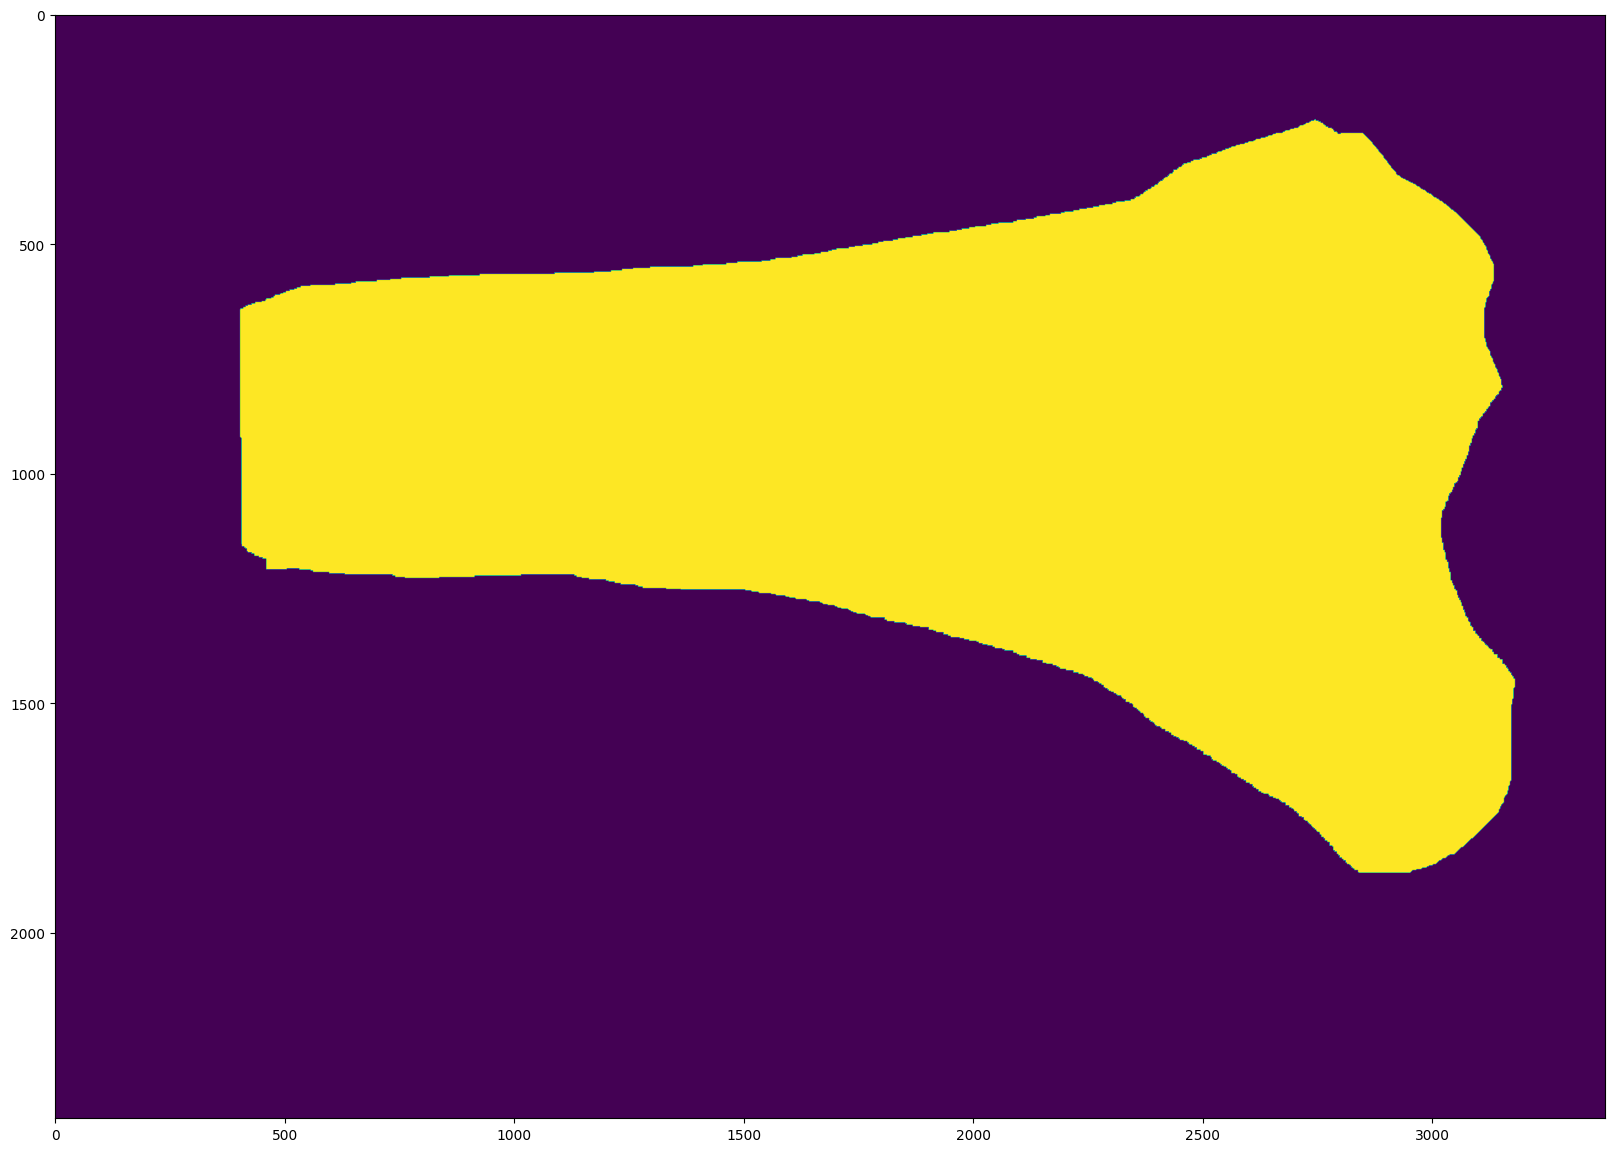

In [3]:
# mask_path = f"/home/dkermany/data/Bone_Project/masks/{filename}.seg.nrrd"
mask_path = f"D:/Datasets/Bone_Mets/masks/{filename}.seg.nrrd"

# Load mask from NRRD
mask, header = nrrd.read(mask_path)
mask = mask.T
# mask = mask[:mask.shape[0]//3, :, :] #For FV10__20190620_111343

# Convert mask from uint8 to uint16
mask = mask.astype(np.uint16)
mask *= 2**16 - 1
print(mask.shape)
print(mask.dtype)

plt.figure(figsize=(20,20))
plt.imshow(mask[40])

In [4]:
# tumor_csv_path = "/home/dkermany/data/Bone_Project/tumor_locations_02_08_2023.csv"
tumor_csv_path = f"D:/Datasets/Bone_Mets/tumor_locations/tumor_locations_02_08_2023.csv"

# Load csv and drop rows with N/A's
tumor_csv = pd.read_csv(tumor_csv_path).dropna()
tumor_csv

Filename  x (um)  y (um)  z (slice)
0    FV10__20190620_111343  2987.0  1760.0       76.0
1    FV10__20190620_111343  2975.0  1755.0       76.0
2    FV10__20190620_111343  2953.0  1715.0       76.0
3    FV10__20190620_111343  3079.0  1680.0       76.0
4    FV10__20190620_111343  2815.0  1342.0       76.0
..                     ...     ...     ...        ...
818  FV10__20190619_111005  6508.0  1024.0       31.0
819  FV10__20190619_111005  6516.0   947.0       32.0
820  FV10__20190619_111005  6211.0  1197.0       31.0
821  FV10__20190619_111005  6565.0  1229.0       35.0
822  FV10__20190619_111005  6274.0  1236.0       23.0

[816 rows x 4 columns]


Tumor Location Marking
----------------------

In [5]:
# Filter tumors for the image in focus
tumor_csv = tumor_csv[tumor_csv.Filename == filename].reset_index(drop=True)
tumor_csv

Filename  x (um)  y (um)  z (slice)
0   FV10__20190620_111343  2987.0  1760.0       76.0
1   FV10__20190620_111343  2975.0  1755.0       76.0
2   FV10__20190620_111343  2953.0  1715.0       76.0
3   FV10__20190620_111343  3079.0  1680.0       76.0
4   FV10__20190620_111343  2815.0  1342.0       76.0
5   FV10__20190620_111343   907.0  1229.0       76.0
6   FV10__20190620_111343  3015.0   875.0       76.0
7   FV10__20190620_111343  3021.0   861.0       76.0
8   FV10__20190620_111343  3055.0   910.0       76.0
9   FV10__20190620_111343  3271.0  1044.0       76.0
10  FV10__20190620_111343  3323.0   746.0       76.0
11  FV10__20190620_111343  3442.0   739.0       76.0
12  FV10__20190620_111343  2876.0  1779.0       67.0
13  FV10__20190620_111343  2961.0   883.0       65.0
14  FV10__20190620_111343  2921.0   896.0       63.0
15  FV10__20190620_111343  3128.0   928.0       62.0
16  FV10__20190620_111343  2912.0  1391.0       60.0
17  FV10__20190620_111343  2859.0  1738.0       59.0
18  FV10__20190620_111343  2351.0   804.0       54.0
19  FV10__20190620_111343  2351.0   804.0       54.0
20  FV10__20190620_111343  2902.0  1760.0       52.0
21  FV10__20190620_111343  2920.0  1768.0       52.0
22  FV10__20190620_111343  3477.0   736.0       49.0
23  FV10__20190620_111343  2940.0  1731.0       44.0
24  FV10__20190620_111343  2412.0   852.0       43.0
25  FV10__20190620_111343  2995.0  1404.0       37.0
26  FV10__20190620_111343  2395.0   830.0       36.0
27  FV10__20190620_111343  2522.0  1608.0       27.0
28  FV10__20190620_111343  2151.0  1544.0       27.0
29  FV10__20190620_111343  1023.0   934.0       14.0
30  FV10__20190620_111343  2099.0  1523.0        5.0
31  FV10__20190620_111343  2786.0  1678.0        1.0
32  FV10__20190620_111343  2682.0  1685.0        1.0
33  FV10__20190620_111343  2682.0  1663.0        1.0
34  FV10__20190620_111343  3144.0  1832.0        1.0

In [6]:
tumor_dict = tumor_csv.to_dict("index")
tumor_dict

{0: {'Filename': 'FV10__20190620_111343',
  'x (um)': 2987.0,
  'y (um)': 1760.0,
  'z (slice)': 76.0},
 1: {'Filename': 'FV10__20190620_111343',
  'x (um)': 2975.0,
  'y (um)': 1755.0,
  'z (slice)': 76.0},
 2: {'Filename': 'FV10__20190620_111343',
  'x (um)': 2953.0,
  'y (um)': 1715.0,
  'z (slice)': 76.0},
 3: {'Filename': 'FV10__20190620_111343',
  'x (um)': 3079.0,
  'y (um)': 1680.0,
  'z (slice)': 76.0},
 4: {'Filename': 'FV10__20190620_111343',
  'x (um)': 2815.0,
  'y (um)': 1342.0,
  'z (slice)': 76.0},
 5: {'Filename': 'FV10__20190620_111343',
  'x (um)': 907.0,
  'y (um)': 1229.0,
  'z (slice)': 76.0},
 6: {'Filename': 'FV10__20190620_111343',
  'x (um)': 3015.0,
  'y (um)': 875.0,
  'z (slice)': 76.0},
 7: {'Filename': 'FV10__20190620_111343',
  'x (um)': 3021.0,
  'y (um)': 861.0,
  'z (slice)': 76.0},
 8: {'Filename': 'FV10__20190620_111343',
  'x (um)': 3055.0,
  'y (um)': 910.0,
  'z (slice)': 76.0},
 9: {'Filename': 'FV10__20190620_111343',
  'x (um)': 3271.0,
  'y (

In [7]:
len(tumor_dict)

35

To calculate the radius of a circle formed by looking at a z-slice of a sphere, you can use the following formula:

radius = sqrt(r^2 - z^2)

where r is the radius of the sphere and z is the distance from the center of the sphere to the z-slice. This formula assumes that the z-slice is perpendicular to the center of the sphere.

For example, suppose you have a sphere with a radius of 5 units and you want to find the radius of the circle formed by a z-slice that is 2 units away from the center of the sphere. In this case, you would plug the values into the formula like this:

radius = sqrt(5^2 - 2^2)
= sqrt(25 - 4)
= sqrt(21)
= 3.605551275463989

So the radius of the circle would be approximately 3.61 units.

In [8]:
tumor_labels = np.zeros(viewer._arr.shape[1:], dtype=np.uint16)

for idx, tumor_info in tumor_dict.items():
    x_um, y_um, z_slice = map(int, (tumor_info["x (um)"], tumor_info["y (um)"], tumor_info["z (slice)"]))
    x, y, z = map(int, (x_um / x_step, y_um / y_step, z_slice-1))
    print(x, y, z)
    
    sphere_radius = 7 # micron
    sphere_z_slices = math.ceil(sphere_radius / z_step)
    
    min_z_step = max(0, z-sphere_z_slices)
    max_z_step = min(z+sphere_z_slices, viewer._arr.shape[1])

    # Label tumor
    for z_prime in range(min_z_step, max_z_step):
        cv2.circle(
            tumor_labels[z_prime],
            (x, y),
            radius=round((sphere_radius**2 - min((z_step*abs(z_prime-z))**2, sphere_radius**2))**0.5),
            color=(4096,4096,4096),
            thickness=-1,
        )
print(tumor_labels.shape)

2404 1417 75
2395 1413 75
2377 1380 75
2479 1352 75
2266 1080 75
730 989 75
2427 704 75
2432 693 75
2459 732 75
2633 840 75
2675 600 75
2771 595 75
2315 1432 66
2384 710 64
2351 721 62
2518 747 61
2344 1119 59
2301 1399 58
1892 647 53
1892 647 53
2336 1417 51
2351 1423 51
2799 592 48
2367 1393 43
1942 685 42
2411 1130 36
1928 668 35
2030 1294 26
1731 1243 26
823 752 13
1690 1226 4
2243 1351 0
2159 1356 0
2159 1338 0
2531 1475 0
(76, 2404, 3376)


In [9]:
# total_image = np.concatenate((viewer._arr, np.expand_dims(tumor_labels, axis=0)), axis=0)
# print(total_image.shape)
# print("Total Image type:", total_image.dtype)

In [10]:
def dict_to_pointlist(dict: tumor_dict) -> np.ndarray:
    pointlist = np.zeros((3, len(tumor_dict)))
    for idx, tumor_info in tumor_dict.items():
        x_um, y_um, z_slice = map(int, (tumor_info["x (um)"], tumor_info["y (um)"], tumor_info["z (slice)"]))
        x, y, z = map(int, (x_um / x_step, y_um / y_step, z_slice-1))
        
        pointlist[0][idx] = x
        pointlist[1][idx] = y
        pointlist[2][idx] = z
        
    return pointlist

In [11]:
tumor_pointlist = dict_to_pointlist(tumor_dict)
print(tumor_pointlist)


[[2404. 2395. 2377. 2479. 2266.  730. 2427. 2432. 2459. 2633. 2675. 2771.
  2315. 2384. 2351. 2518. 2344. 2301. 1892. 1892. 2336. 2351. 2799. 2367.
  1942. 2411. 1928. 2030. 1731.  823. 1690. 2243. 2159. 2159. 2531.]
 [1417. 1413. 1380. 1352. 1080.  989.  704.  693.  732.  840.  600.  595.
  1432.  710.  721.  747. 1119. 1399.  647.  647. 1417. 1423.  592. 1393.
   685. 1130.  668. 1294. 1243.  752. 1226. 1351. 1356. 1338. 1475.]
 [  75.   75.   75.   75.   75.   75.   75.   75.   75.   75.   75.   75.
    66.   64.   62.   61.   59.   58.   53.   53.   51.   51.   48.   43.
    42.   36.   35.   26.   26.   13.    4.    0.    0.    0.    0.]]


In [12]:
del tumor_labels

Vessel Segmentation
-----------------------------

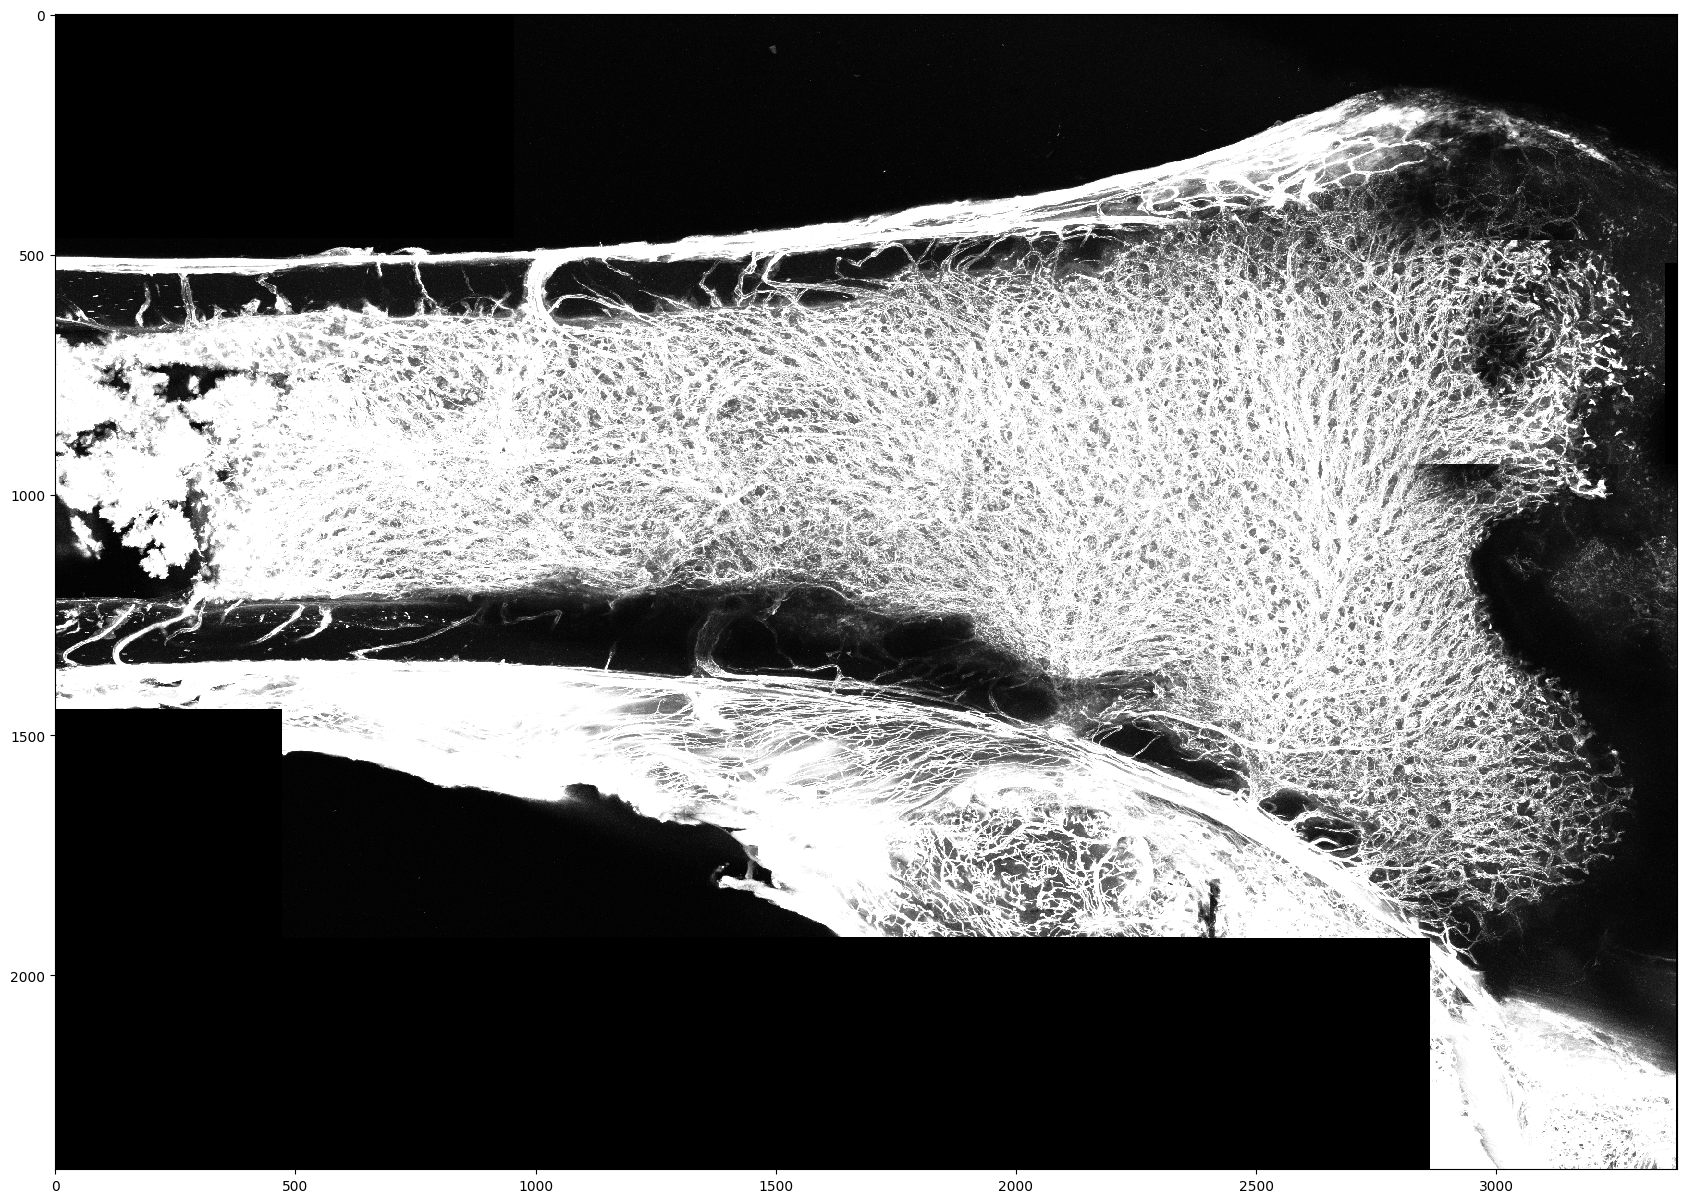

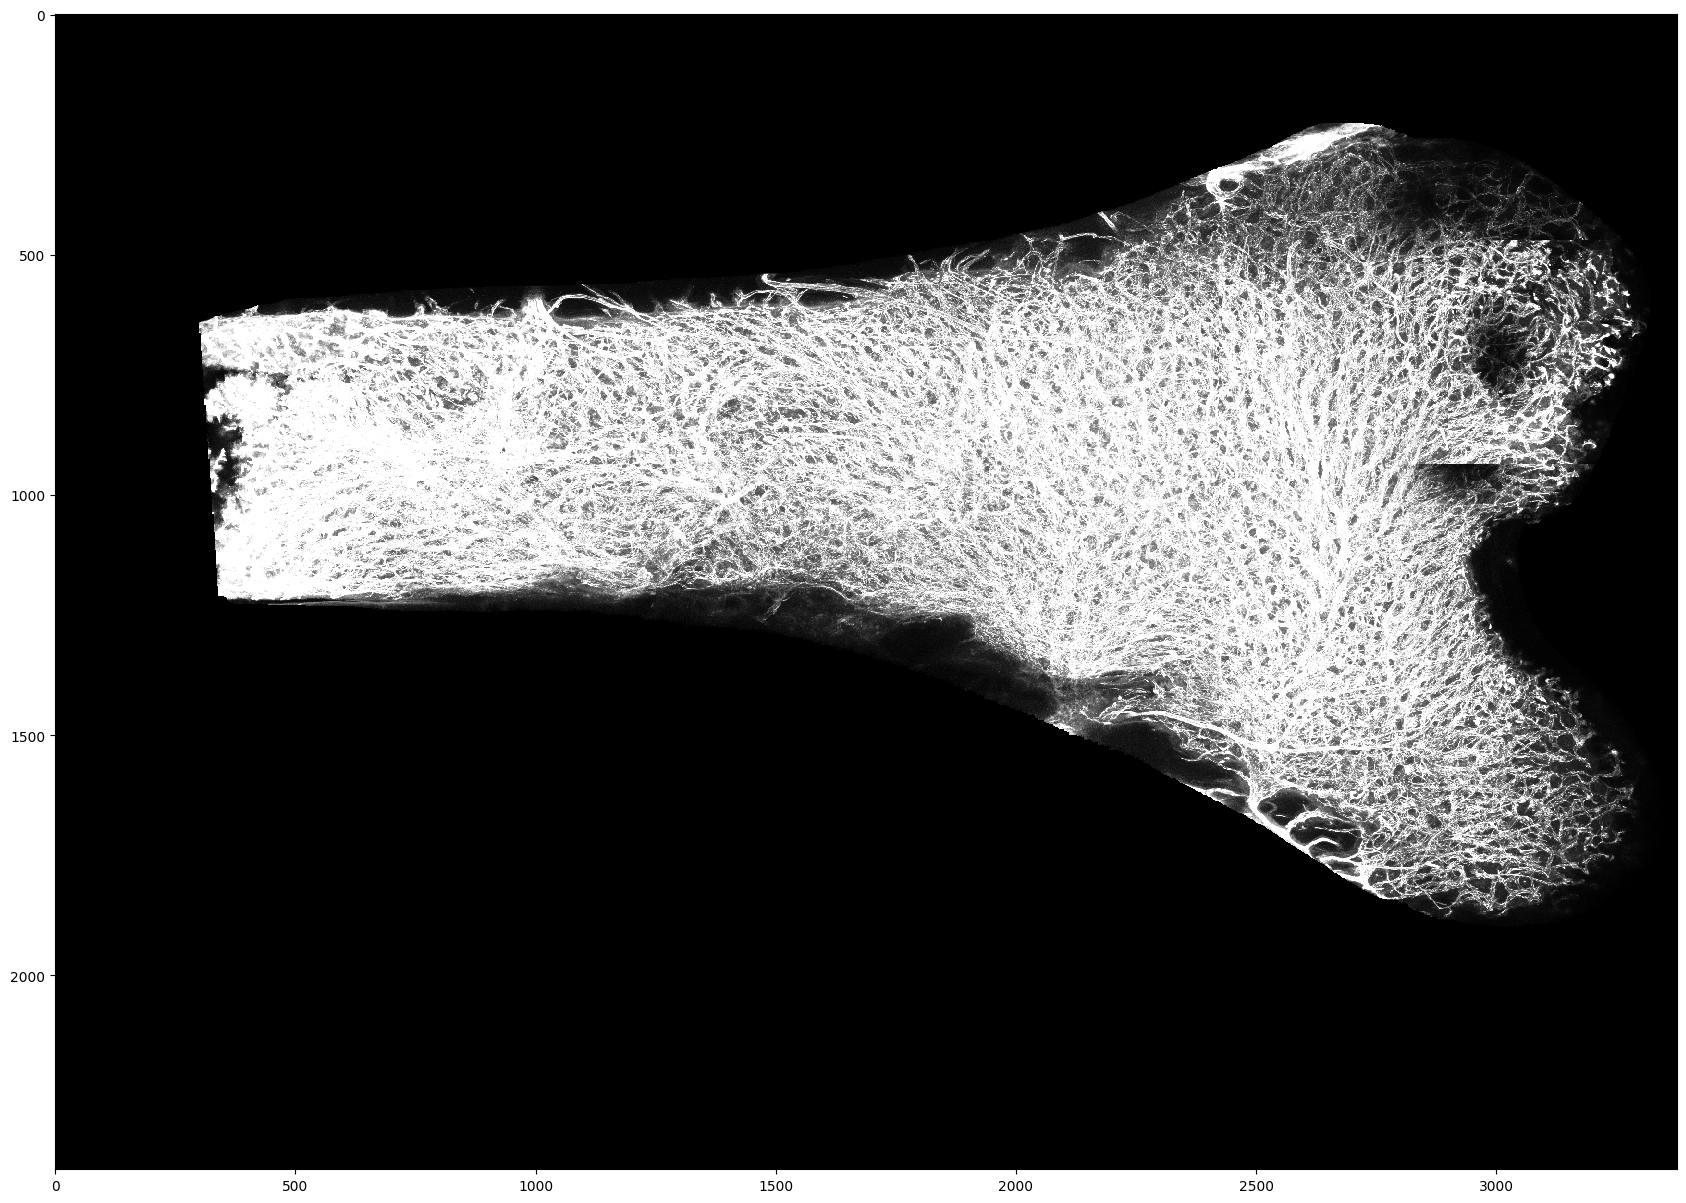

In [13]:
original_vessels = cle.push(viewer.get_array()[2])
plt.figure(figsize=(30,15))
cle.imshow(original_vessels)

masked_vessels = cle.mask(original_vessels, mask)
plt.figure(figsize=(30,15))
cle.imshow(masked_vessels)

del original_vessels 

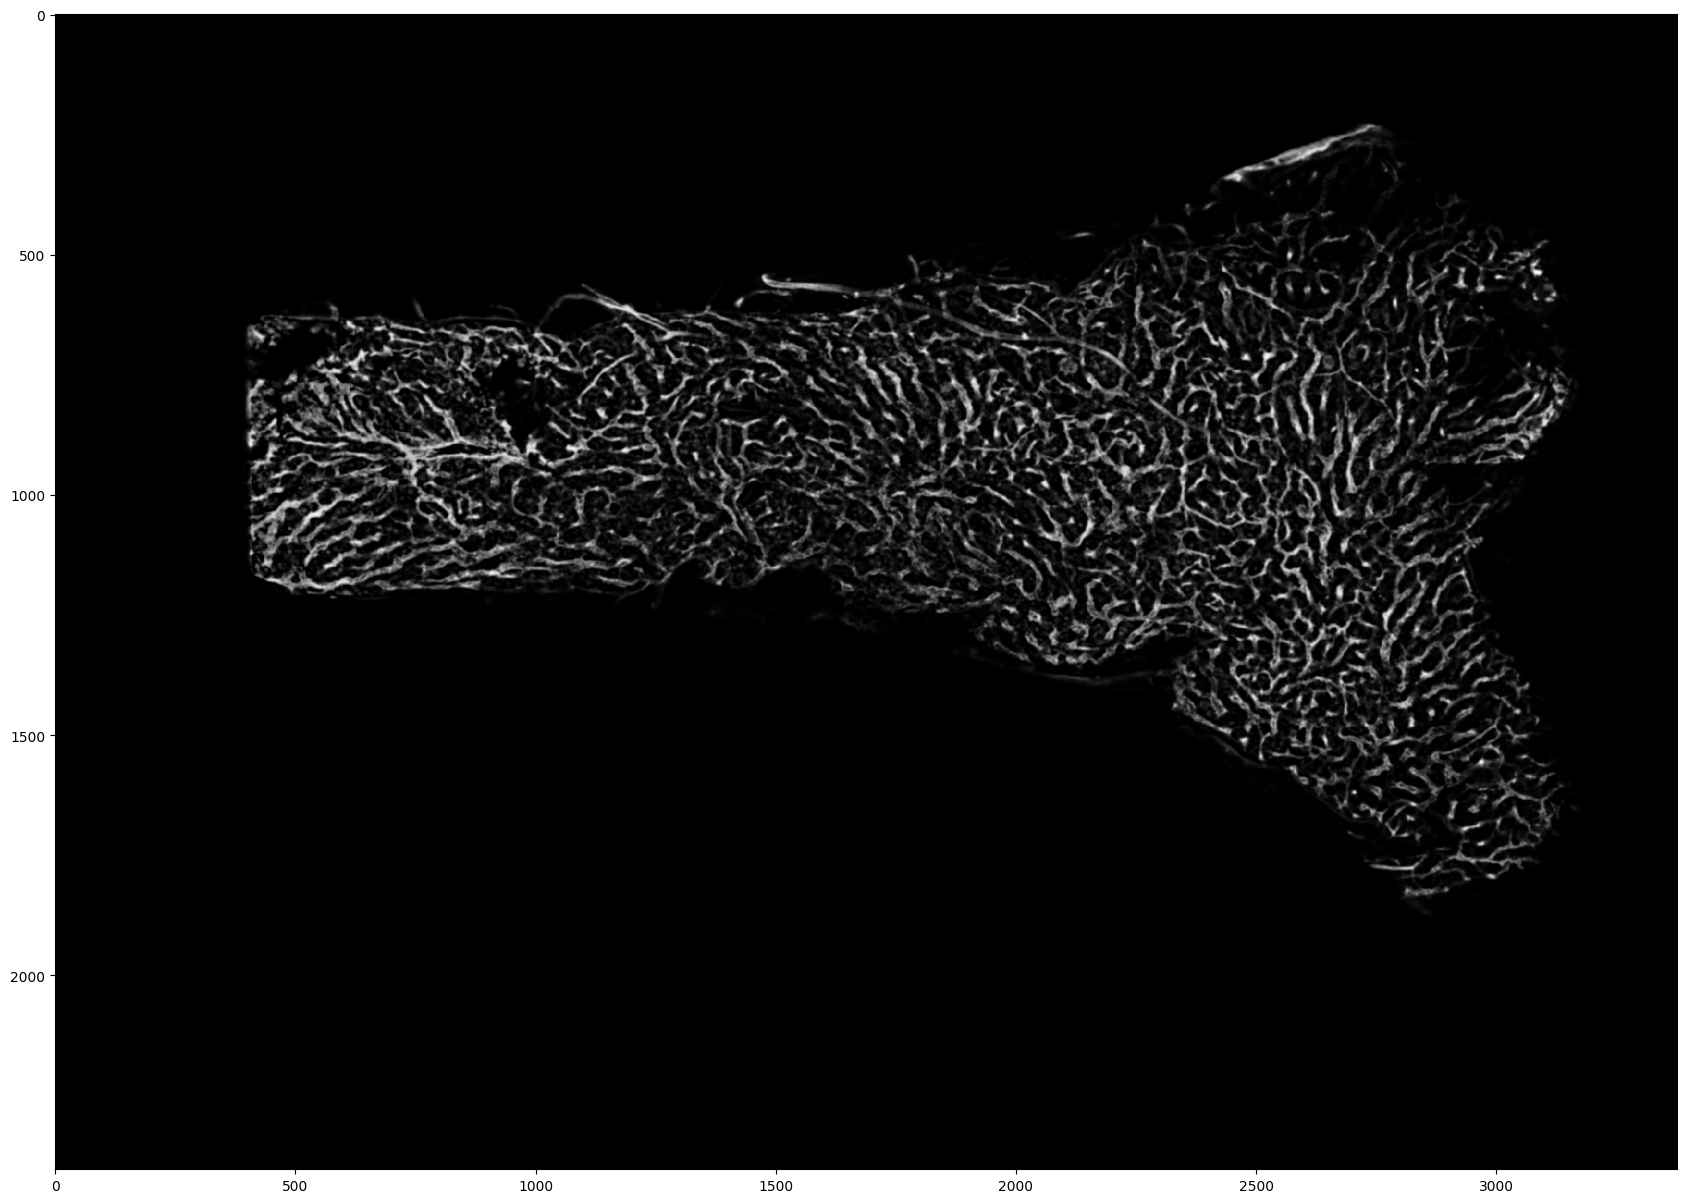

In [14]:
img_gaussian = cle.gaussian_blur(masked_vessels, sigma_x=2, sigma_y=2, sigma_z=2)
backgrund_subtracted = cle.top_hat_box(img_gaussian, radius_x=10, radius_y=10, radius_z=5)

plt.figure(figsize=(30,15))
cle.imshow(backgrund_subtracted[40])

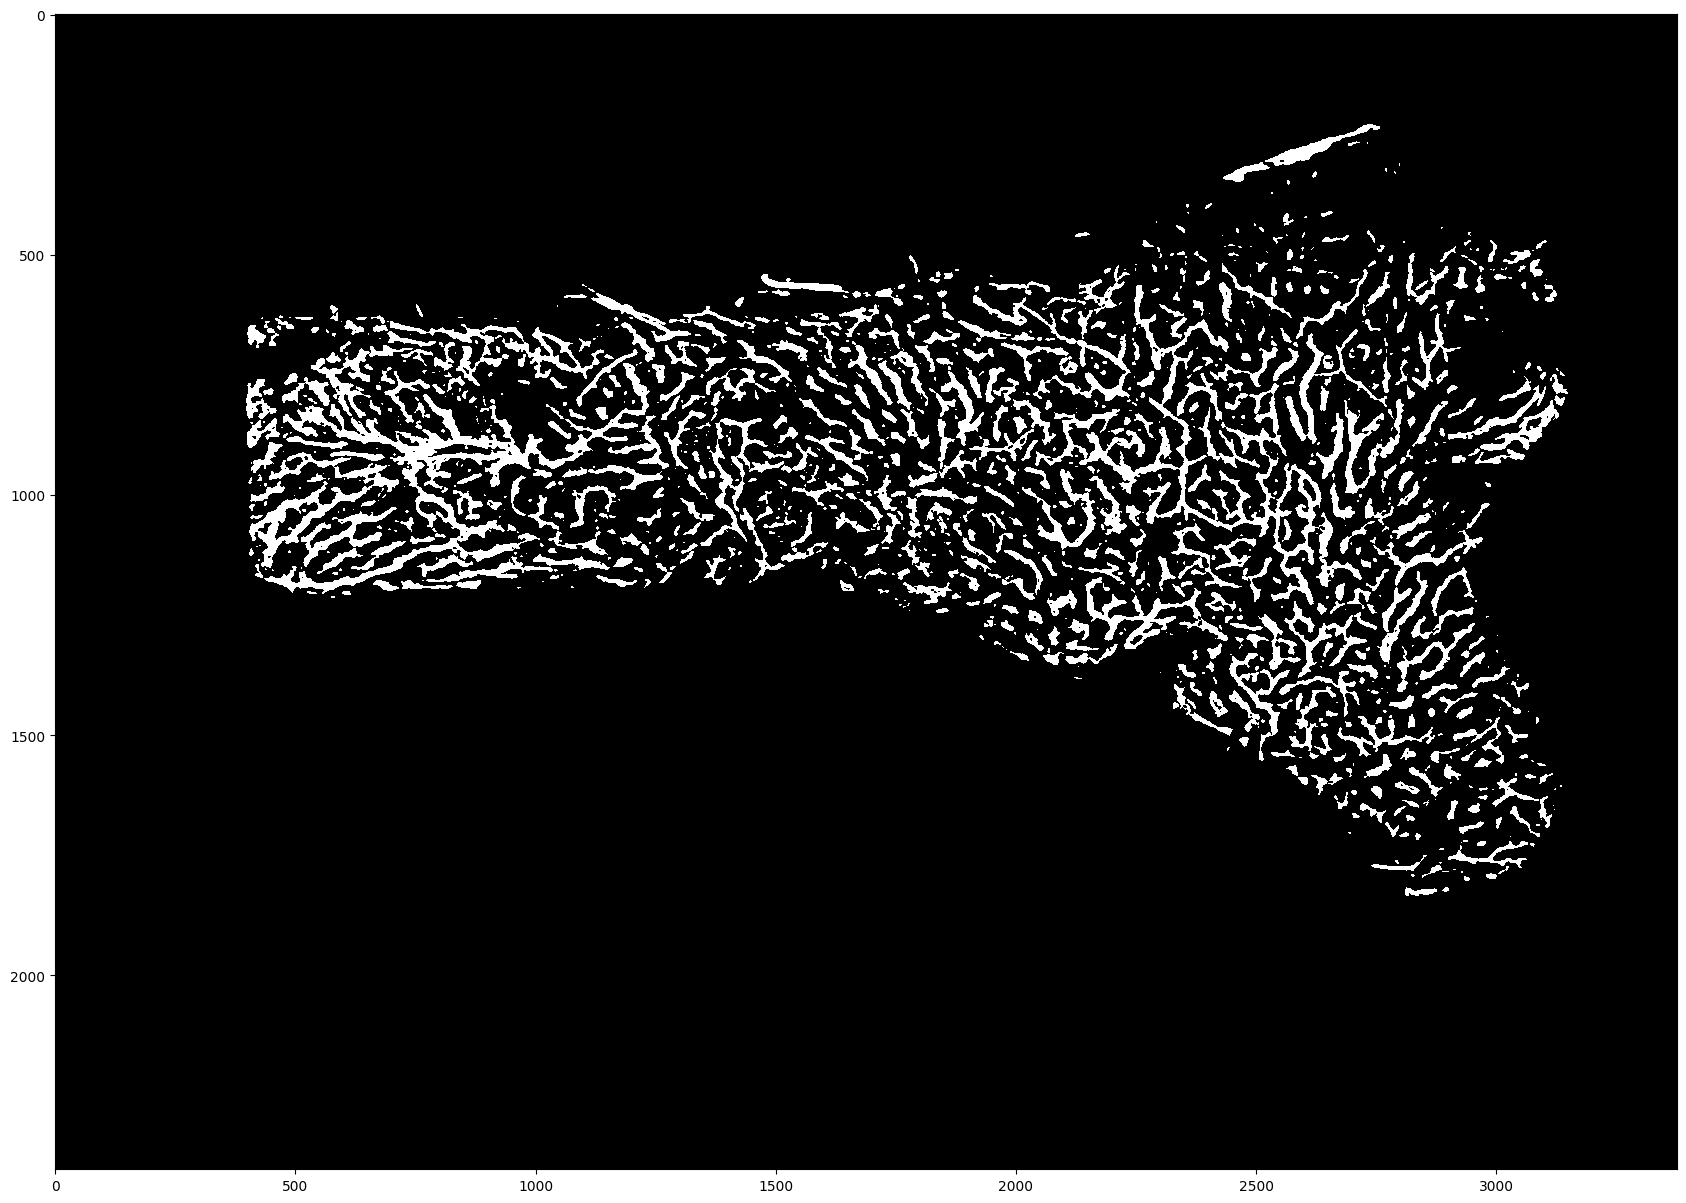

In [15]:
thresh2 = cle.threshold_otsu(backgrund_subtracted)

plt.figure(figsize=(30,15))
cle.imshow(thresh2[40])

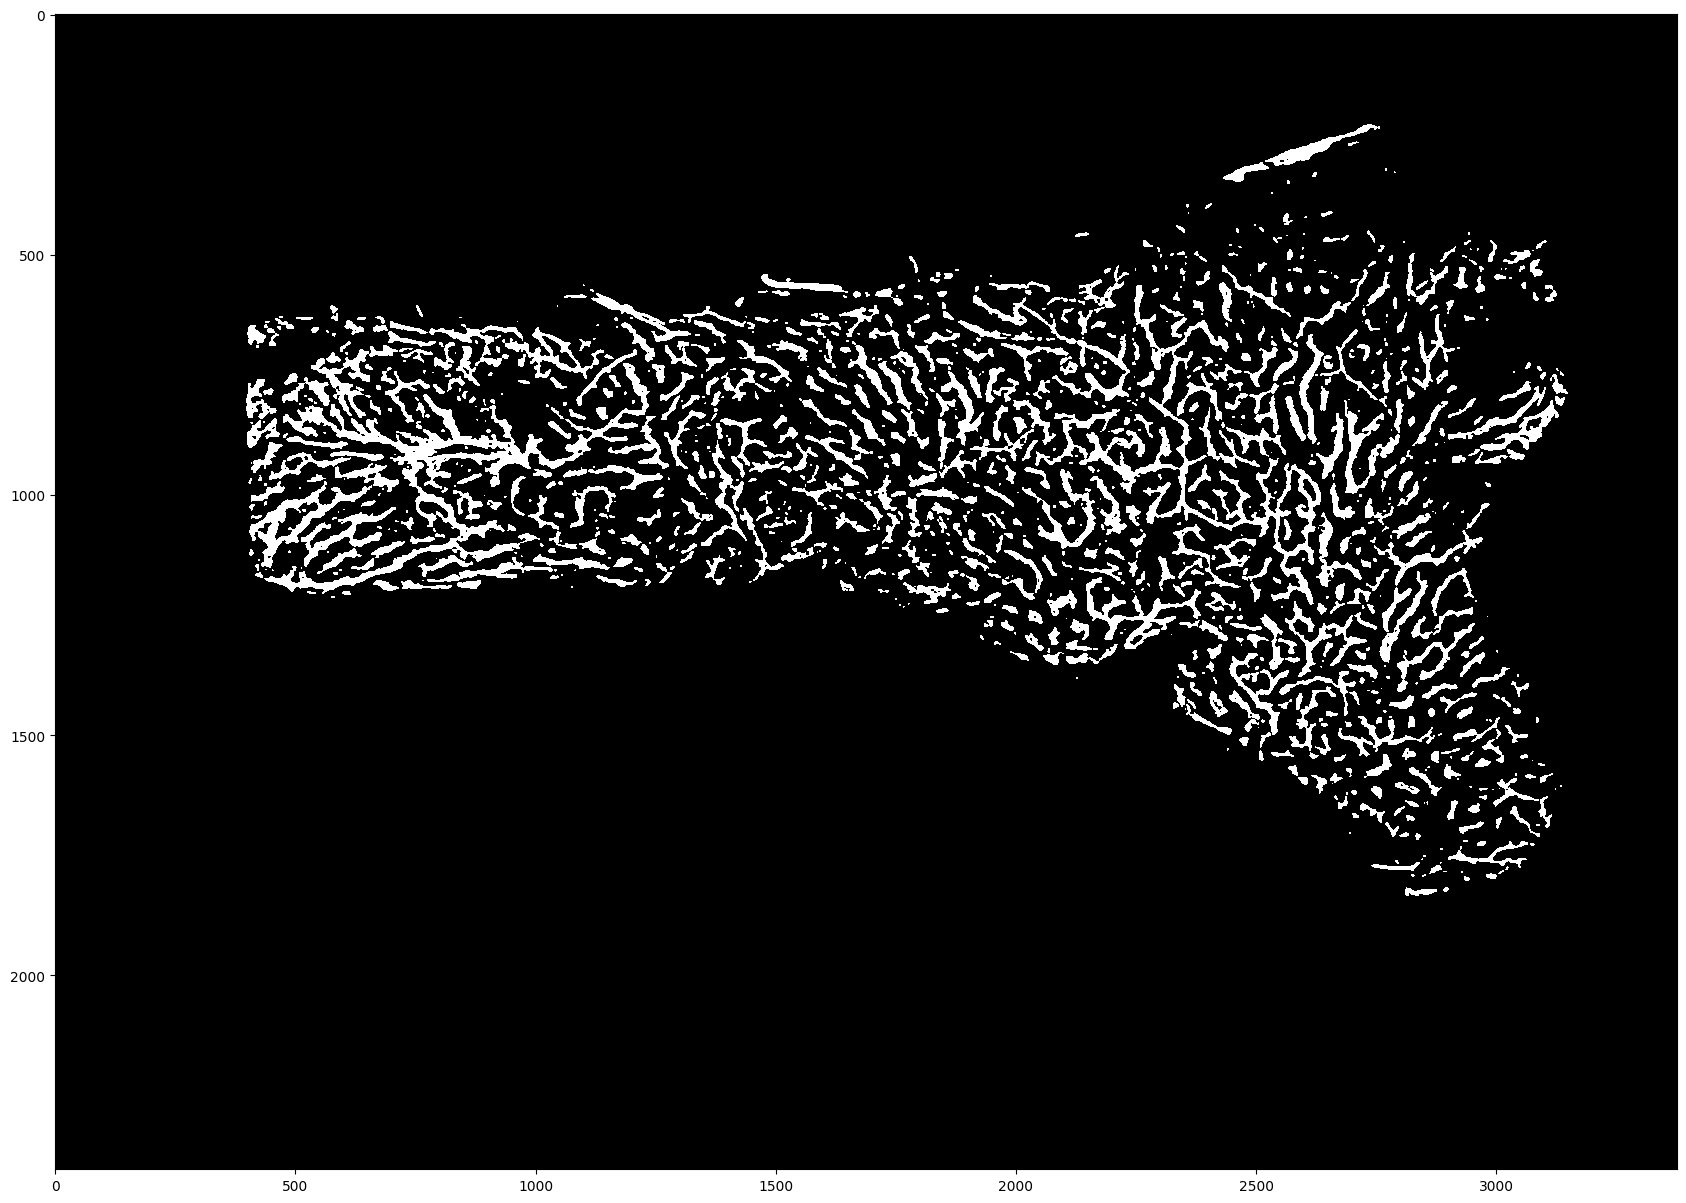

In [16]:
# Morphological openning
erosion = cle.erode_box(thresh2)
dilation = cle.dilate_box(erosion)

plt.figure(figsize=(30,15))
cle.imshow(dilation[40])

In [17]:
del erosion, masked_vessels, img_gaussian, backgrund_subtracted, thresh2

In [18]:
# Convert dilation from uint8 to uint16
dilation = dilation.astype(np.uint16)
dilation *= 2**10 - 1 #2**16 - 1

# Add vessel segmentation result to total_image
# total_image = np.concatenate((total_image, np.expand_dims(cle.pull(dilation), axis=0)), axis=0)
# print(total_image.shape)
# print(total_image.dtype)

Find Vessel Bifurcations
----

In [19]:
def get_unique_orientations(cube):
    """
    List all possible unique variations of the given 3d array involving both rotation and reflection
    Inspired by @Colonel Panic at https://stackoverflow.com/questions/33190042/how-to-calculate-all-24-rotations-of-3d-array
    """
    if np.unique(cube, return_counts=True)[1][1] < 4:
        print("WARNING: <4 1s found within kernel. 4 is needed to detect branches. Ignore if using 2 for finding tips")

    variations = []

    def rotations4(cube, axes):
        """List the four rotations of the given 3d array in the plane spanned by the given axes."""
        for i in range(4):
            variations.append(np.rot90(cube, i, axes))

    for arr in [cube, np.flip(cube, axis=0), np.flip(cube, axis=1), np.flip(cube, axis=2)]:
    # for arr in [cube]:
        # imagine shape is pointing in axis 0 (up)
        # 4 rotations about axis 0
        rotations4(arr, (1,2))

        # rotate 180 about axis 1, now shape is pointing down in axis 0
        # 4 rotations about axis 0
        rotations4(np.rot90(arr, 2, axes=(0,2)), (1,2))

        # rotate 90 or 270 about axis 1, now shape is pointing in axis 2
        # 8 rotations about axis 2
        rotations4(np.rot90(arr, 1, axes=(0,2)), (0,1))
        rotations4(np.rot90(arr, -1, axes=(0,2)), (0,1))

        # rotate about axis 2, now shape is pointing in axis 1
        # 8 rotations about axis 1
        rotations4(np.rot90(arr, 1, axes=(0,1)), (0,2))
        rotations4(np.rot90(arr, -1, axes=(0,1)), (0,2))

    return np.unique(variations, axis=0)

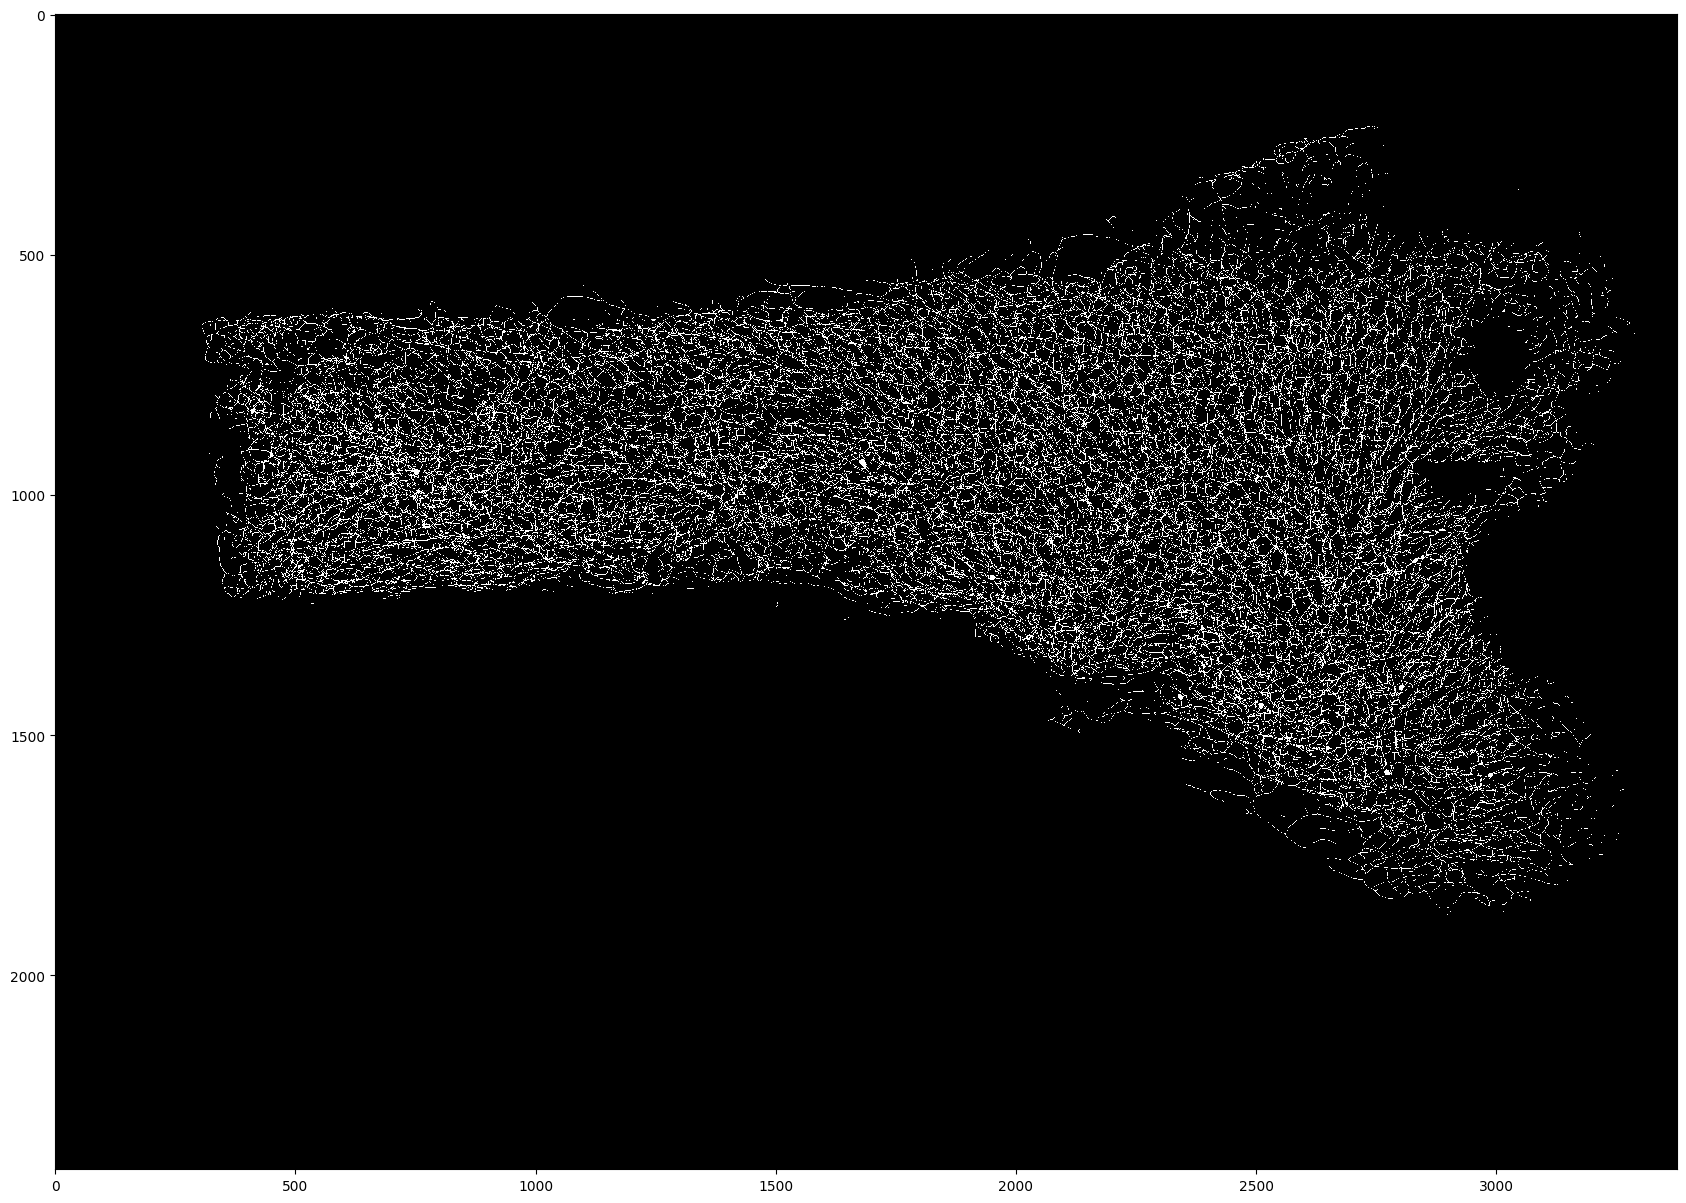

In [20]:
from skimage.morphology import skeletonize_3d
skeleton = skeletonize_3d(dilation)

plt.figure(figsize=(30,15))
cle.imshow(skeleton)

In [21]:
# total_image = np.concatenate((total_image, np.expand_dims(cle.pull(skeleton), axis=0)), axis=0)
del dilation

In [22]:
import sys
print(sys.path)

['c:\\Users\\danie\\BoneSegmentation\\ipynb\\confocal_3D', 'C:\\Users\\danie\\.pyenv\\pyenv-win\\versions\\3.8.10\\python38.zip', 'C:\\Users\\danie\\.pyenv\\pyenv-win\\versions\\3.8.10\\DLLs', 'C:\\Users\\danie\\.pyenv\\pyenv-win\\versions\\3.8.10\\lib', 'C:\\Users\\danie\\.pyenv\\pyenv-win\\versions\\3.8.10', 'c:\\Users\\danie\\.virtualenvs\\BoneSegmentation-dpCXn3BL', '', 'c:\\Users\\danie\\.virtualenvs\\BoneSegmentation-dpCXn3BL\\lib\\site-packages', 'c:\\Users\\danie\\.virtualenvs\\BoneSegmentation-dpCXn3BL\\lib\\site-packages\\win32', 'c:\\Users\\danie\\.virtualenvs\\BoneSegmentation-dpCXn3BL\\lib\\site-packages\\win32\\lib', 'c:\\Users\\danie\\.virtualenvs\\BoneSegmentation-dpCXn3BL\\lib\\site-packages\\Pythonwin', 'C:/Users/danie/BoneSegmentation']


In [23]:
kernel_cache_path = "../../lib/unique_kernels.npy"
if os.path.exists(kernel_cache_path):
    # Load unique kernels from cache
    print("Unique kernel cache found! Loading...")
    kernels = load_from_cache(kernel_cache_path)
    print(f"{len(kernels)} kernels loaded!")
else:
    # Get unique kernels
    print("Kernel cache not found! Generating...")
    kernels = get_unique_kernels()


Unique kernel cache found! Loading...
4670 kernels loaded!


100%|██████████| 4670/4670 [10:48<00:00,  7.20it/s]


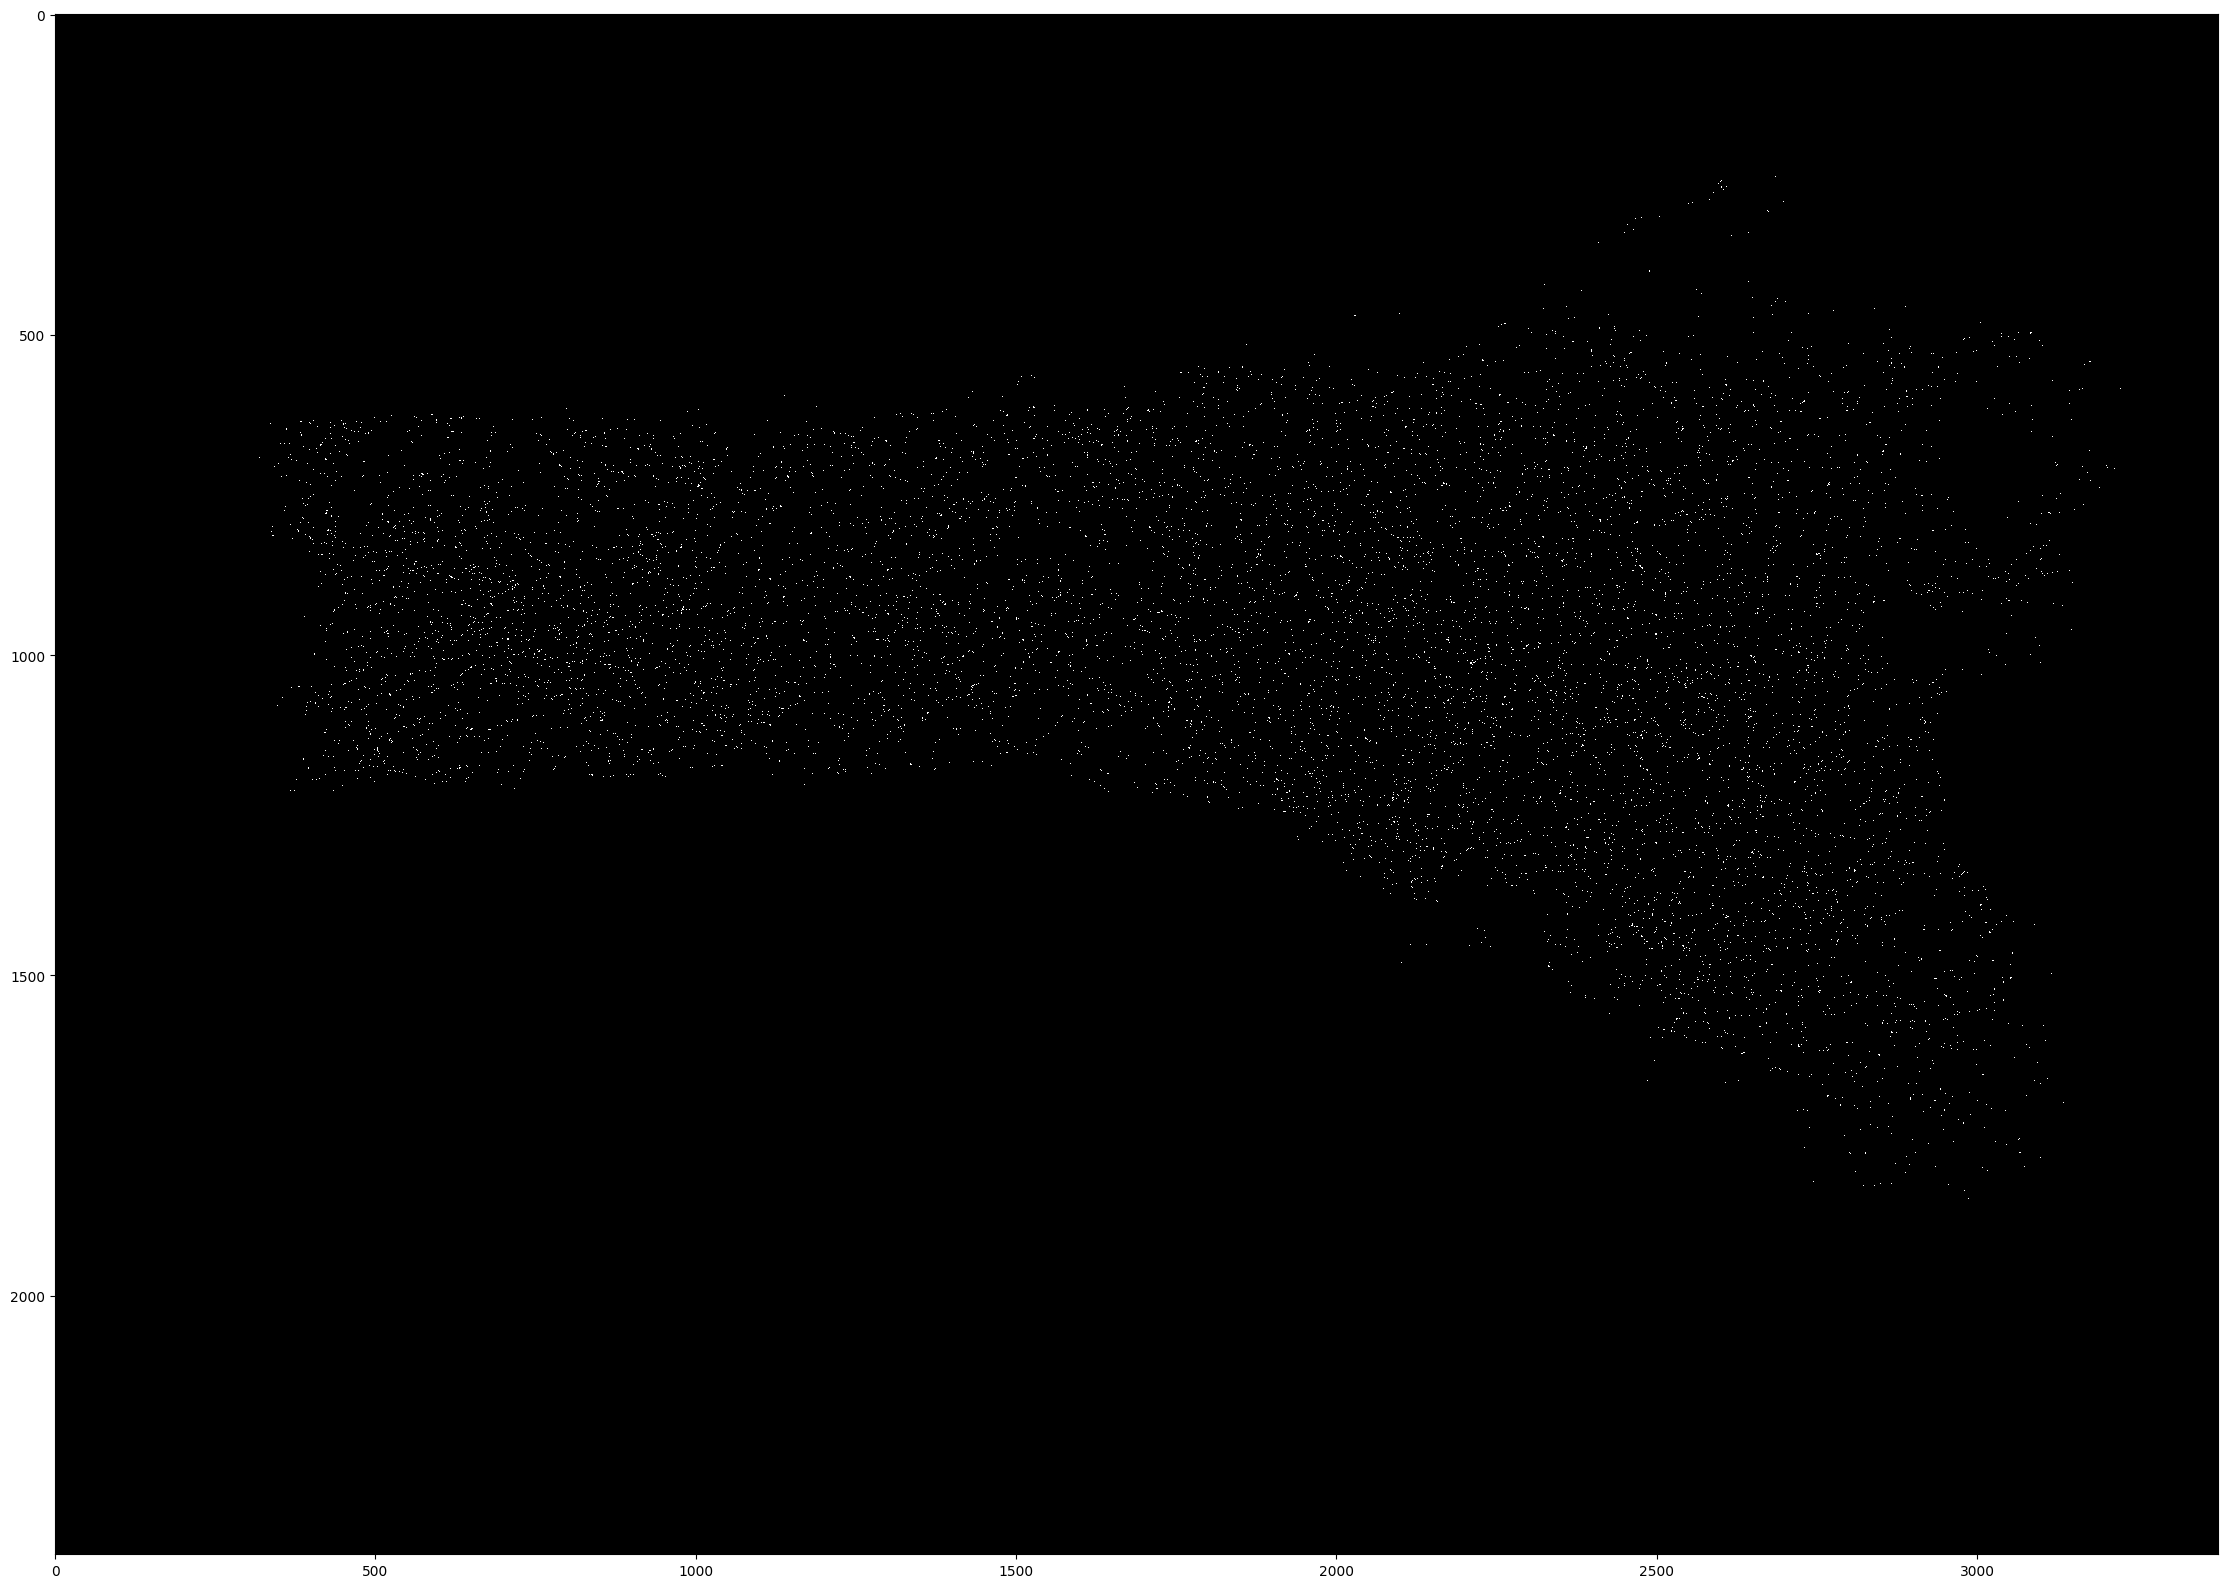

In [24]:
branch_pts_img = cp.zeros(skeleton.shape, dtype=int)
cp_skeleton = cp.asarray(skeleton)
for kernel in tqdm(kernels):
    branch_pts_img = cp.logical_or(
        binary_hit_or_miss(cp_skeleton, structure1=cp.asarray(kernel)),
        branch_pts_img,
    )
branch_pts_img = cp.asnumpy(branch_pts_img.astype(np.uint8) * 255)

plt.figure(figsize=(30,20))
cle.imshow(branch_pts_img)

# print(total_image.shape)
# total_image = np.concatenate((total_image, np.expand_dims(branch_pts_img, axis=0)), axis=0)
# print(total_image.shape)

In [25]:
# 24411 old
np.count_nonzero(branch_pts_img)

24413

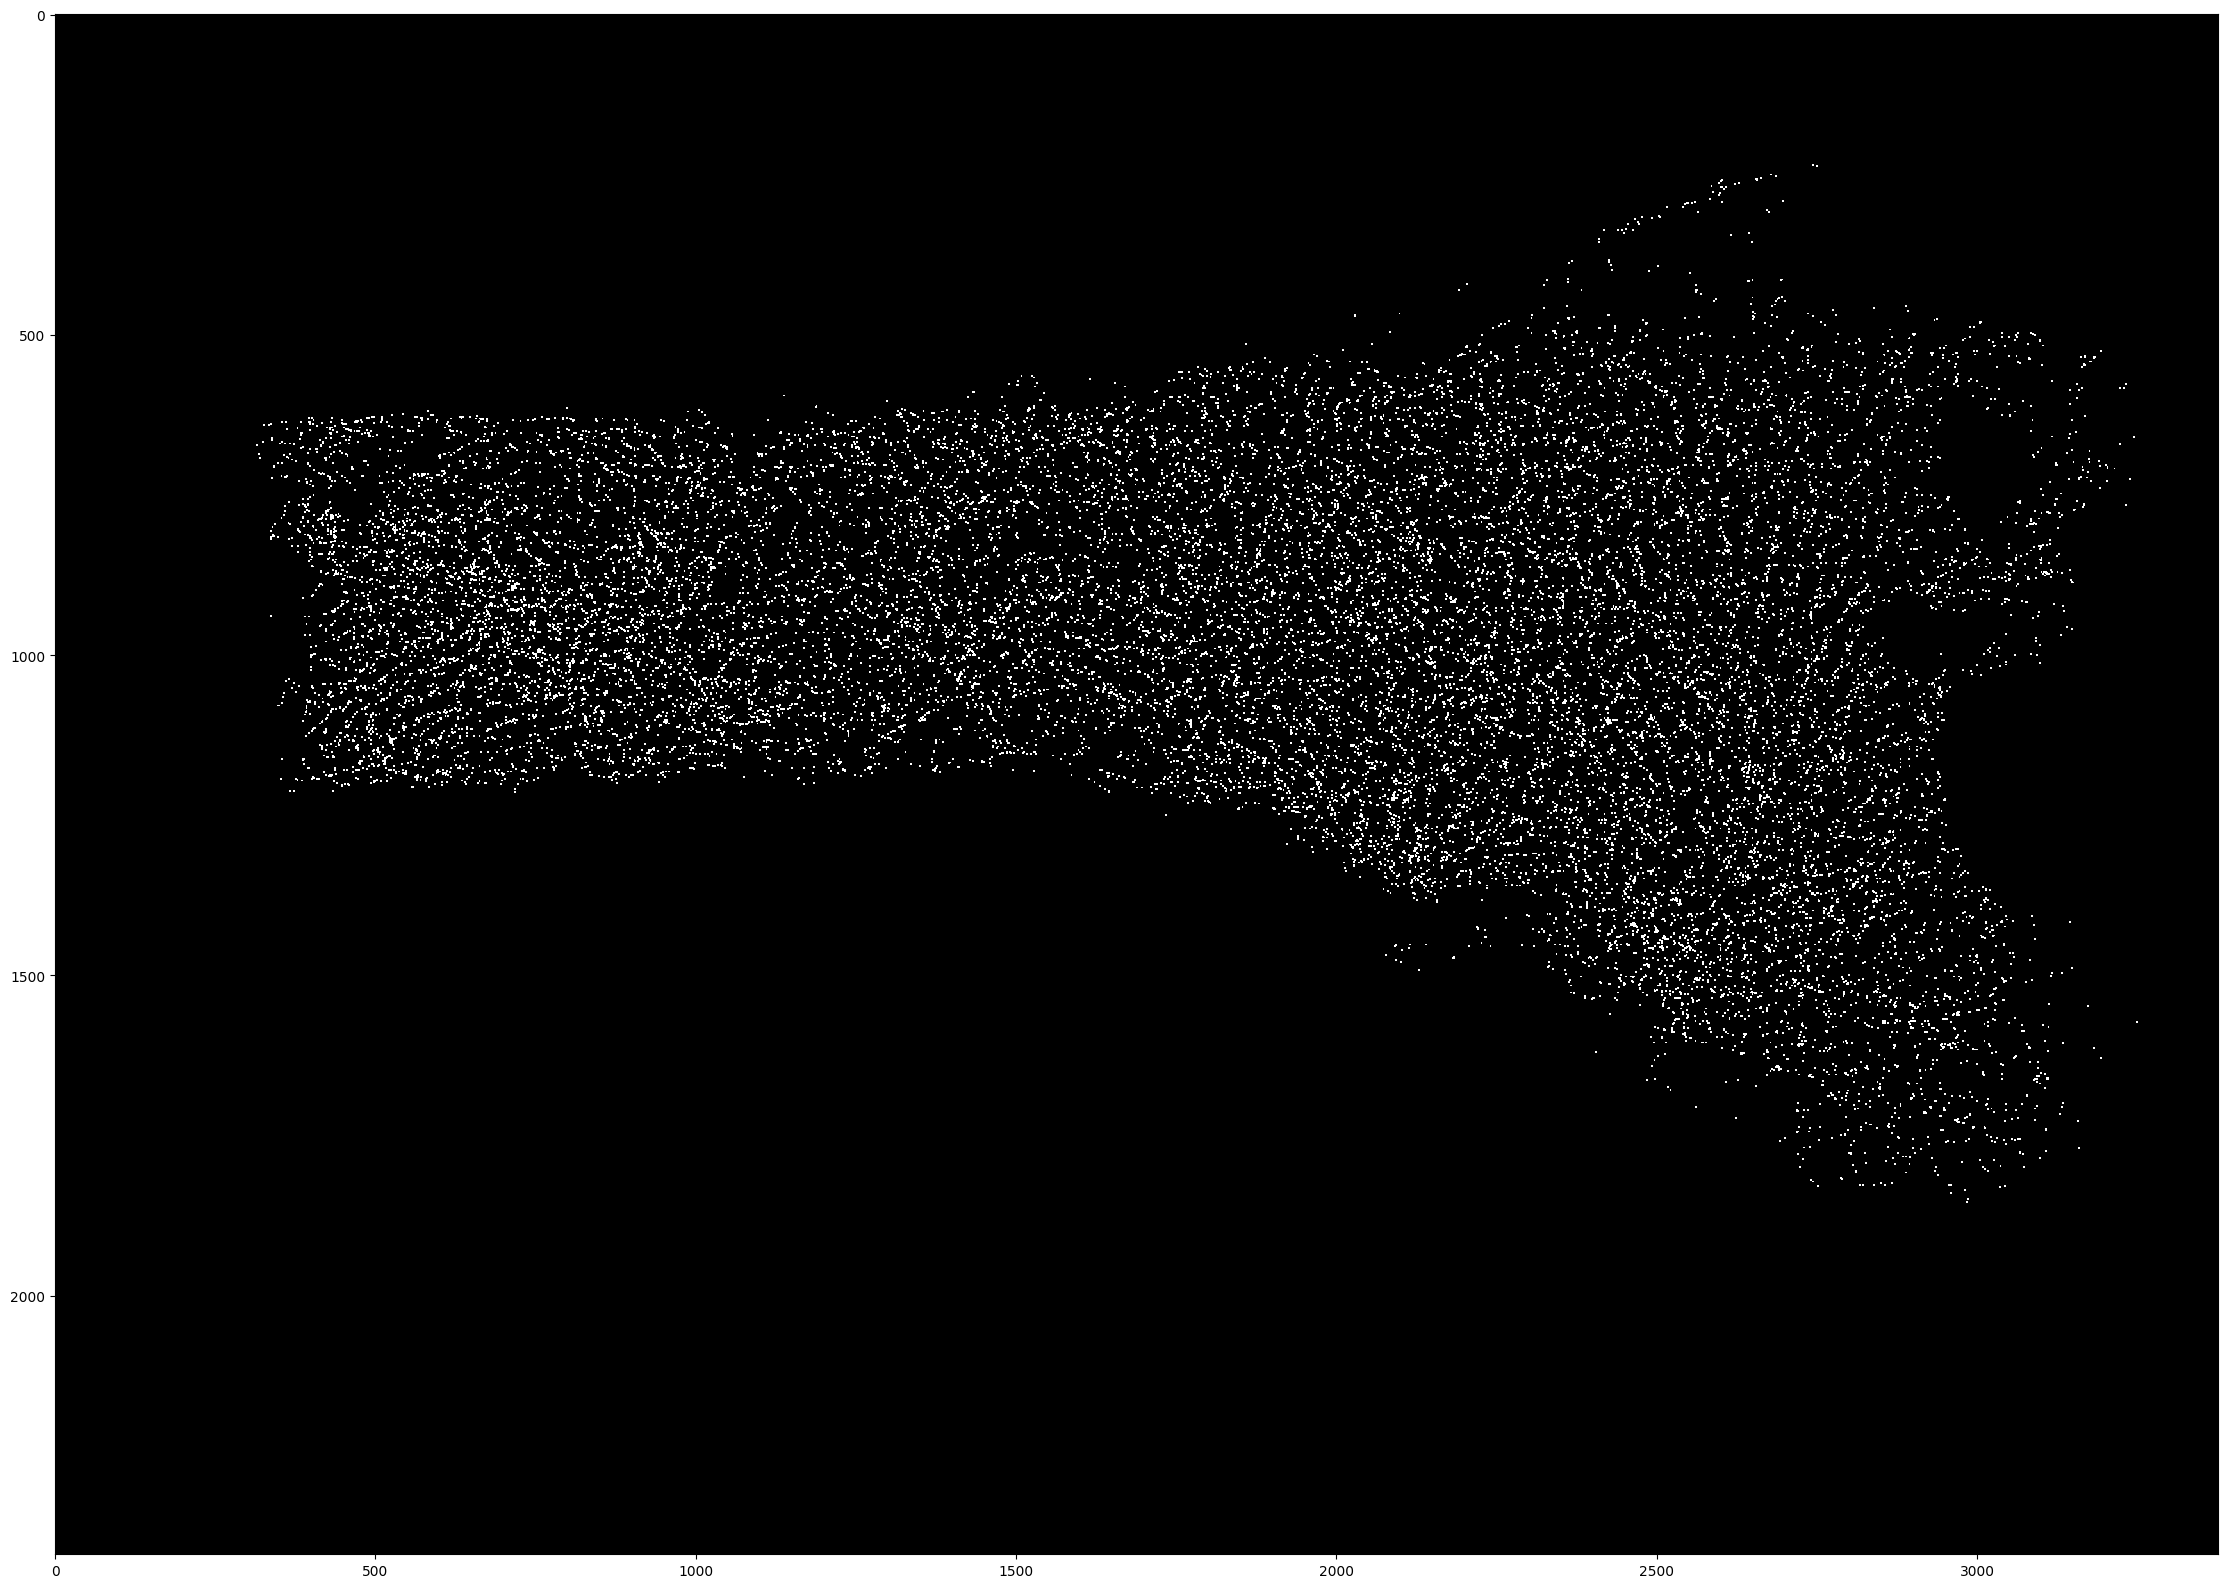

In [26]:
dilated_branch_pts_img = cle.dilate_box(branch_pts_img)

plt.figure(figsize=(30,20))
cle.imshow(dilated_branch_pts_img)

In [27]:
subtracted_pts = cle.binary_subtract(skeleton, dilated_branch_pts_img)
# vessel_segments = cle.connected_components_labeling_box(subtracted_pts)

In [28]:
del branch_pts_img, dilated_branch_pts_img, cp_skeleton

25819


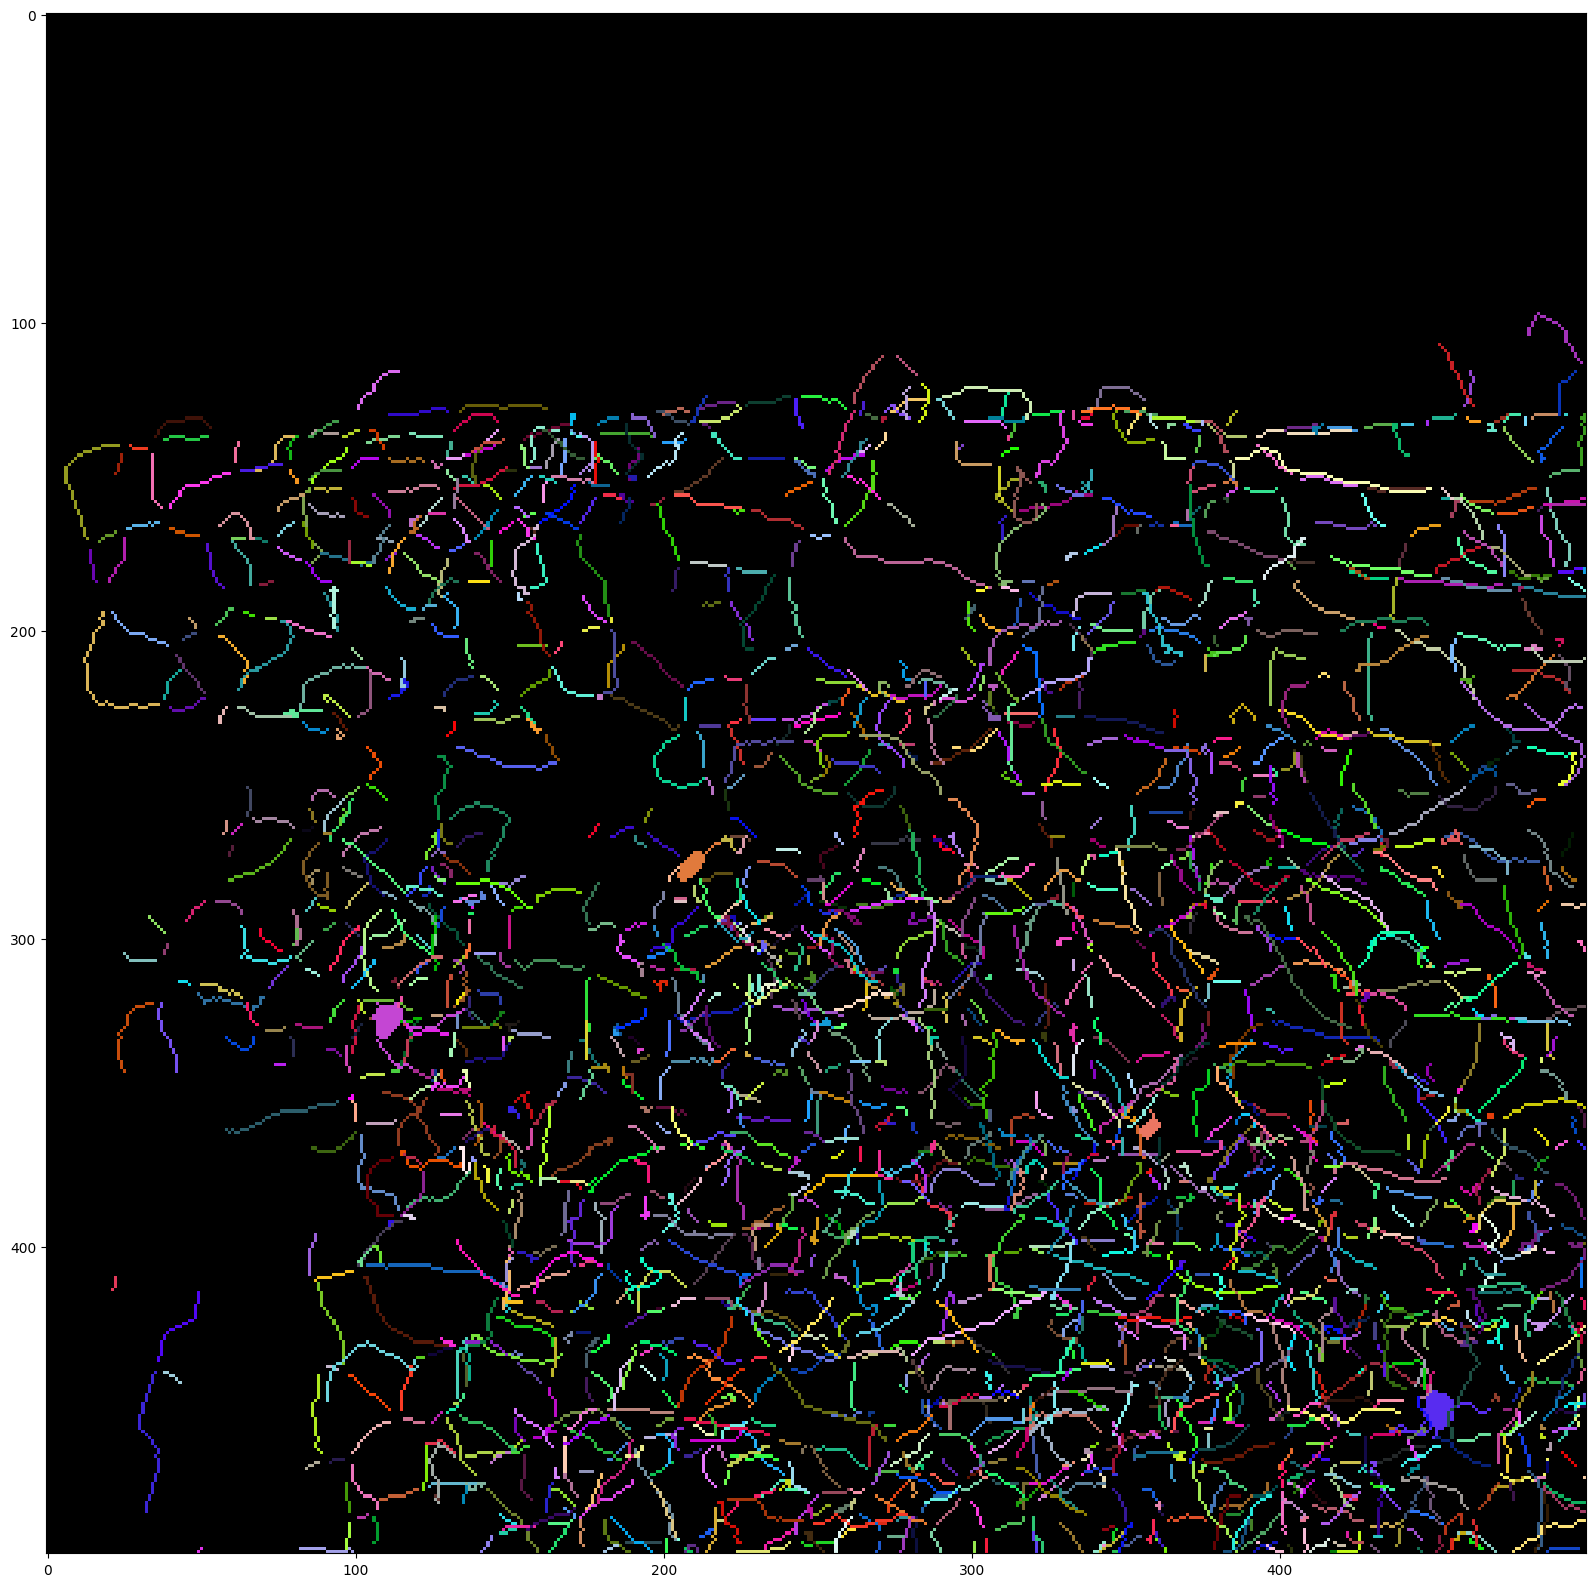

In [29]:
import cc3d
subtracted_pts = cc3d.dust(cle.pull(subtracted_pts), threshold=4, in_place=False)
vessel_segments2, N = cc3d.connected_components(subtracted_pts, return_N=True)
print(N)

plt.figure(figsize=(30,20))
cle.imshow(vessel_segments2[:, 500:1000, 300:800], labels=True)

In [30]:
tip_kernels = []

# Filter 1
tip_kernels.append(np.array([[[0, 0, 0],
                              [0, 0, 0],
                              [0, 0, 0]
                             ],
                             [[0, 0, 1],
                              [0, 1, 0],
                              [0, 0, 0]
                             ],
                             [[0, 0, 0],
                              [0, 0, 0],
                              [0, 0, 0]]]))

# Filter 2
tip_kernels.append(np.array([[[0, 0, 0],
                              [0, 0, 0],
                              [0, 0, 0]
                             ],
                             [[0, 1, 0],
                              [0, 1, 0],
                              [0, 0, 0]
                             ],
                             [[0, 0, 0],
                              [0, 0, 0],
                              [0, 0, 0]]]))

# Filter 3
tip_kernels.append(np.array([[[0, 0, 1],
                              [0, 0, 0],
                              [0, 0, 0]
                             ],
                             [[0, 0, 0],
                              [0, 1, 0],
                              [0, 0, 0]
                             ],
                             [[0, 0, 0],
                              [0, 0, 0],
                              [0, 0, 0]]]))

unique_tip_kernels = []
for kernel in tip_kernels:
    unique_tip_kernels.extend(get_unique_orientations(kernel))

In [31]:
a = cp.array([])

print(type(a))
print(isinstance(a, cp.ndarray))

<class 'cupy.ndarray'>
True


In [32]:
def trim_zeros(arr):
    """Returns a trimmed view of an n-D array excluding any outer
    regions which contain only zeros.
    """
    if isinstance(arr, cp.ndarray):
        nonzero = cp.nonzero
    elif isinstance(arr, np.ndarray):
        nonzero = np.nonzero
    else:
        raise ValueError("arr needs to be np or cp ndarray type")

    slices = tuple(slice(idx.min(), idx.max() + 1) for idx in nonzero(arr))
    return arr[slices]

def euclidean_distance(point1, point2):
    """
    Calculate the Euclidean distance between two points.

    Args:
    point1 (array-like): An array-like object representing the first point.
    point2 (array-like): An array-like object representing the second point.

    Returns:
    float: The Euclidean distance between the two points.
    """
    # Use NumPy's linalg.norm function to calculate the Euclidean distance
    return np.linalg.norm(np.array(point1)-np.array(point2))

In [38]:
import dijkstra3d

# Remove 0 from list
vessel_segments = cp.asarray(vessel_segments2)
segment_labels = cp.unique(vessel_segments)[1:]

tortuosity_lib = {}
for label in tqdm(segment_labels):
    segment = cp.where(vessel_segments==int(label), True, False)
    cropped_segment = trim_zeros(segment)

    tips_img = cp.zeros(cropped_segment.shape, dtype=int)
    for kernel in unique_tip_kernels:
        kernel = cp.asarray(kernel)
        tips_img = cp.logical_or(binary_hit_or_miss(cropped_segment, structure1=kernel), tips_img)
    tips_img = cp.asnumpy(tips_img.astype(np.uint8) * 255)
    n_tips = tips_img.sum() / 255

    # Check that there are only 2 tips found. 
    if n_tips == 2:
        start_pt = [i[0] for i in np.nonzero(tips_img)]
        end_pt = [i[1] for i in np.nonzero(tips_img)]

    # More than 2 tips indicates that a branching point was not identified and subtracted properly.
    elif n_tips > 2:
        # print(f"Error with label: {label}")
        # print(cropped_segment.shape)
        cropped_segment = cp.asnumpy(cropped_segment)
        z, y, x = np.nonzero(tips_img)

        paths = []
        for tip_a, tip_b in itertools.combinations(zip(z, y, x), 2):
            path = dijkstra3d.binary_dijkstra(cropped_segment, source=tip_a, target=tip_b)
            paths.append((tip_a, tip_b, path))
        
        start_pt, end_pt, longest_path = sorted(paths, key=lambda x: x[2].shape[0], reverse=True)[0]
        cropped_segment = np.zeros(cropped_segment.shape, dtype=int)
        cropped_segment[tuple(longest_path.T)] = 1

    # Less than 2 tips means this is an unrecoverable segment. Set tortuosity to 0 so it is removed in the next step
    # and skip
    else:
        print(f"Skipping abnormal segment #{int(label)}...")
        tortuosity_lib[int(label)] = 0
        continue

    euclid_dist = euclidean_distance(start_pt, end_pt)
    geodesic_dist = cropped_segment.sum()
    tortuosity = 1. * geodesic_dist / euclid_dist

    tortuosity_lib[int(label)] = min(float(tortuosity), 3.)

print("Finished calculating tortuosity for each segment")
print("Now replacing label with tortuosity value in full image")


 12%|█▏        | 3036/25819 [03:12<23:55, 15.87it/s]

Skipping abnormal segment #3035...


 42%|████▏     | 10882/25819 [11:33<15:31, 16.03it/s]

Skipping abnormal segment #10879...


 48%|████▊     | 12415/25819 [13:13<13:54, 16.06it/s]

Skipping abnormal segment #12413...


 86%|████████▌ | 22077/25819 [23:31<04:05, 15.26it/s]

Skipping abnormal segment #22075...


100%|██████████| 25819/25819 [27:32<00:00, 15.63it/s]

Finished calculating tortuosity for each segment
Now replacing label with tortuosity value in full image


In [39]:
sorted(tortuosity_lib.items(), key=lambda x: x[1], reverse=True)

[(376, 3),
 (878, 3),
 (1074, 3),
 (2366, 3),
 (5129, 3),
 (5438, 3),
 (5490, 3),
 (11511, 3),
 (11577, 3),
 (12221, 3),
 (13008, 3),
 (13663, 3),
 (14294, 3),
 (14331, 3),
 (15150, 3),
 (16305, 3),
 (19627, 3),
 (20526, 3),
 (22614, 3),
 (22925, 3),
 (24396, 3),
 (25501, 3),
 (7386, 2.9139711855430965),
 (3664, 2.8507658044184883),
 (24848, 2.789943329851663),
 (7782, 2.6098507150250914),
 (16948, 2.5),
 (25150, 2.4980511884786787),
 (587, 2.4576957615571215),
 (4670, 2.4053511772118195),
 (7691, 2.363515791475006),
 (8270, 2.3046638387921274),
 (17730, 2.3),
 (498, 2.2728658742898165),
 (7805, 2.229882438741499),
 (4, 2.1489185543445424),
 (7515, 2.090909090909091),
 (1640, 2.088931871468374),
 (240, 2.0795009796401454),
 (22338, 2.0754980866510833),
 (23730, 2.0586009418626614),
 (24065, 2.054911784133451),
 (2726, 2.0530251534508177),
 (21869, 2.024549924108956),
 (17631, 2.0206878278440343),
 (1106, 2.0180747504302268),
 (819, 2.007739367977589),
 (19033, 2.003469213361885),
 (375

In [49]:
def normalize(x, min, max):
    return (x - min) / (max - min)

def replace_np_values(arr: np.ndarray, map: dict) -> np.ndarray:
    fn = np.vectorize(lambda x: map.get(x, 0))
    return fn(arr)

t_min, t_max = min(tortuosity_lib.values()), max(tortuosity_lib.values())
normalized_map = {k: normalize(v, t_min, t_max) for k, v in tortuosity_lib.items()}

result_array = replace_np_values(cp.asnumpy(vessel_segments).astype(np.float32), normalized_map)

MemoryError: 

In [48]:
np.unique(result_array)

dtype('int32')

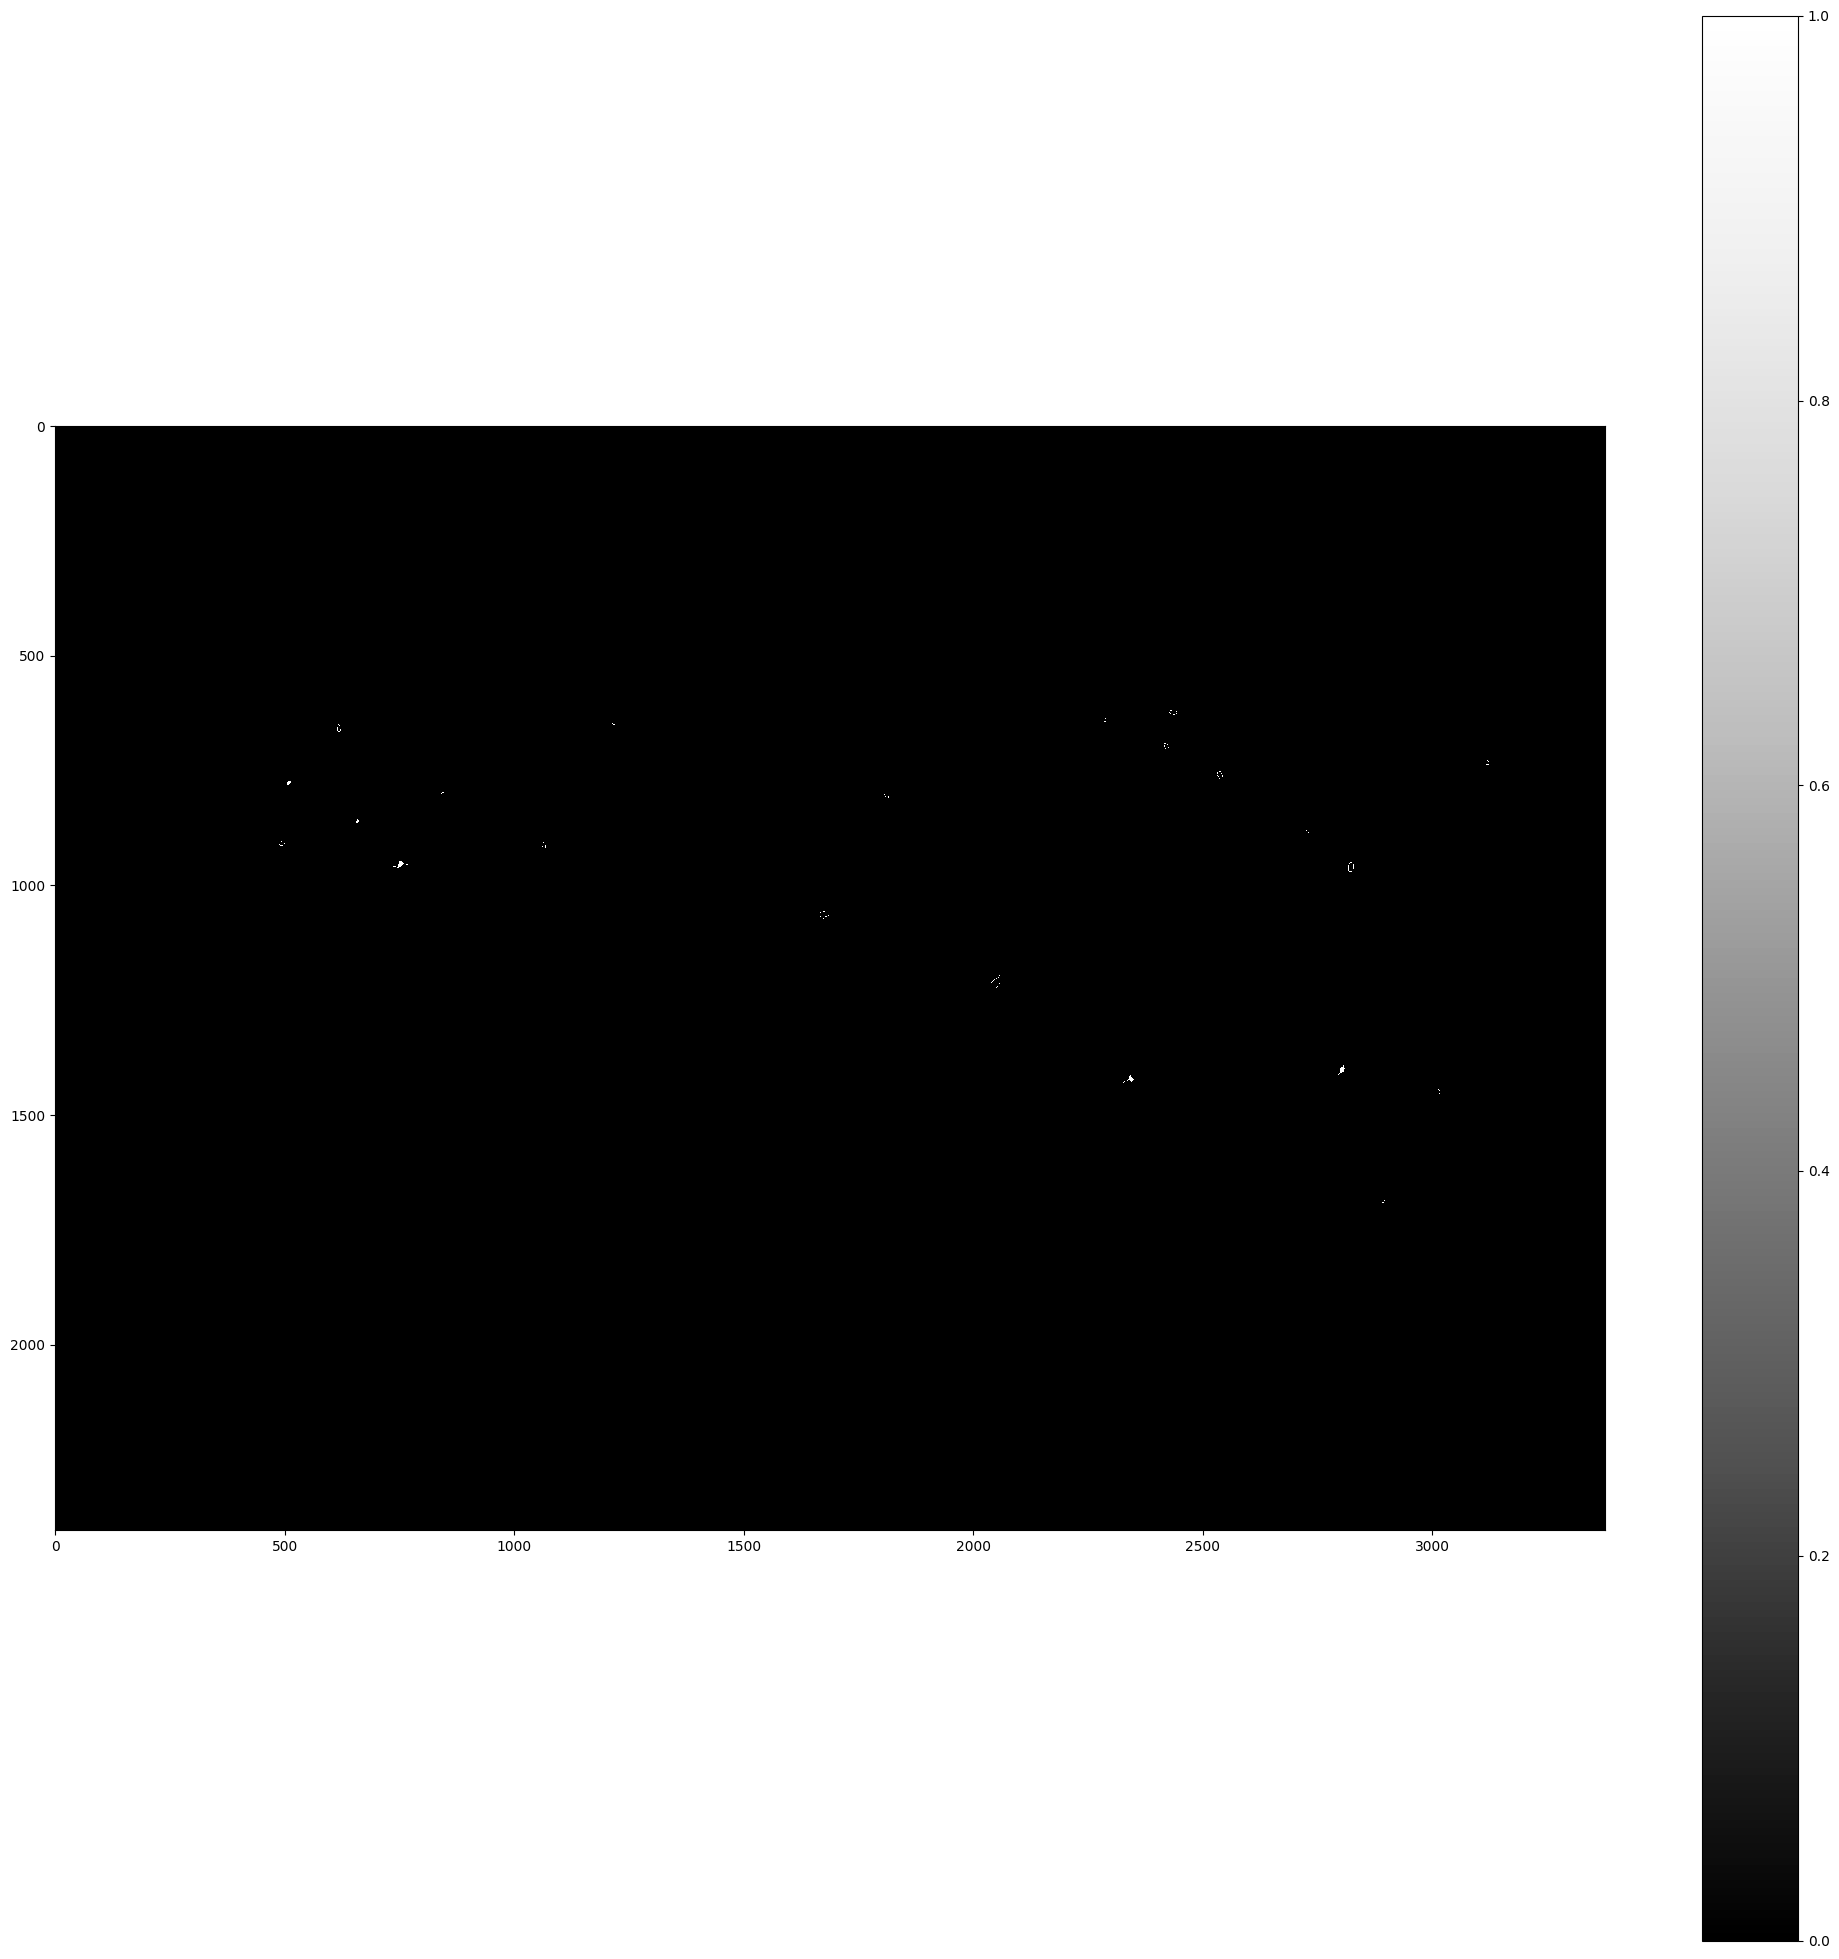

In [41]:


plt.figure(figsize=(25,25))
cle.imshow(cle.push(result_array), colorbar=True,)
# for label, tortuosity in tqdm(tortuosity_lib.items()):
#     vessel_segments = cp.where(vessel_segments==int(label), tortuosity_lib[label], vessel_segments)


In [34]:
np.unique(vessel_segments, return_counts=True)

array([0.00000000e+00, 7.91256568e-01, 8.05387266e-01, ...,
       2.58170000e+04, 2.58180000e+04, 2.58190000e+04])

In [54]:
one_segment = np.where(vessel_segments2 == 1199, 1, 0)
# print(cle.statistics_of_labelled_pixels(skeleton, vessel_segments))
print(one_segment.sum())

12


(12, 10, 5)


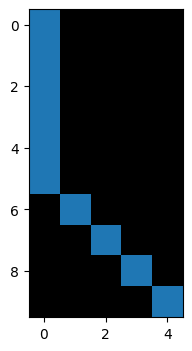

In [51]:
cropped_one_segment = trim_zeros(one_segment)
print(cropped_one_segment.shape)
# print(cropped_one_segment)
plt.figure(figsize=(6,4))
cle.imshow(cle.push(cropped_one_segment), labels=True)

In [56]:
tips_img = cp.zeros(cropped_one_segment.shape, dtype=int)
for kernel in unique_tip_kernels:
    kernel = cp.asarray(kernel)
    tips_img = cp.logical_or(binary_hit_or_miss(cp.asarray(cropped_one_segment), structure1=kernel), tips_img)
tips_img = cp.asnumpy(tips_img.astype(np.uint8) * 255)
n_tips = tips_img.sum() / 255

# Check that there are only 2 tips found. 
if n_tips == 2:
    start_pt = [i[0] for i in np.nonzero(tips_img)]
    end_pt = [i[1] for i in np.nonzero(tips_img)]
    print(euclidean_distance(start_pt, end_pt))
    print(cropped_one_segment.sum())

14.7648230602334
12


In [59]:
print(start_pt)
print(end_pt)

[0, 0, 0]
[11, 9, 4]


In [57]:
import napari
viewer = napari.view_image(cropped_one_segment)

In [ ]:
unique_tip_kernels = []

for kernel in tip_kernels:
    unique_tip_kernels.extend(get_unique_orientations(kernel))

In [ ]:
tips_img = cp.zeros(cropped_one_segment.shape, dtype=int)

for kernel in tqdm(unique_tip_kernels):
    kernel = cp.asarray(kernel)
    tips_img = cp.logical_or(binary_hit_or_miss(cp.asarray(cropped_one_segment), structure1=kernel),
                                   tips_img)
tips_img = cp.asnumpy(tips_img.astype(np.uint8) * 255)

# assert tips_img.sum()/255 == 2

start_pt = [i[0] for i in np.nonzero(tips_img)]
end_pt = [i[1] for i in np.nonzero(tips_img)]

euclid_dist = euclidean_distance(start_pt, end_pt)
geodesic_dist = cropped_one_segment.sum()

print(f"Geodesic distance: {geodesic_dist}")
print(f"Euclidean distance: {euclid_dist}")
print(f"Tortuosity: {geodesic_dist / euclid_dist}")

plt.figure(figsize=(30,20))
cle.imshow(tips_img)

In [ ]:
del skeleton, branch_pts_img

NG2 Segmentation
---------------------------

In [ ]:
original_ng2 = cle.push(viewer.get_array()[1])
plt.figure(figsize=(30,15))
cle.imshow(original_ng2)

masked_ng2 = cle.mask(original_ng2, mask)
plt.figure(figsize=(30,15))
cle.imshow(masked_ng2)

del original_ng2

In [ ]:
img_gaussian = cle.gaussian_blur(masked_ng2, sigma_x=2, sigma_y=2, sigma_z=2)
plt.figure(figsize=(30,15))
cle.imshow(img_gaussian)

del masked_ng2

In [ ]:
backgrund_subtracted = cle.top_hat_box(img_gaussian, radius_x=10, radius_y=10, radius_z=5)

plt.figure(figsize=(30,15))
cle.imshow(backgrund_subtracted)

In [ ]:
filename

In [ ]:
# 1500  FV10__20190620_111343
# 1200  FV10__20181004_122358
# 1200  FV10__20181005_104242
# 1500 'FV10__20181008_104428'
# 1200  FV10__20181009_103052
# 1000 'FV10__20181106_121902'

thresh1 = np.where(backgrund_subtracted > 1200, 65535, 0)

plt.figure(figsize=(30,15))
cle.imshow(thresh1)

In [ ]:
# thresh2 = cle.threshold_otsu(backgrund_subtracted)

# plt.figure(figsize=(30,15))
# cle.imshow(thresh2)

In [ ]:
# Morphological opening
kernel = np.ones((5,5), np.uint8)
erosion = cle.erode_box(thresh1) #thresh2
dilation = cle.dilate_box(erosion)

plt.figure(figsize=(30,15))
cle.imshow(dilation)
print(dilation.shape)

In [ ]:
del erosion, thresh1, backgrund_subtracted, img_gaussian

In [ ]:
labels = cle.connected_components_labeling_box(dilation)
print(labels.shape)
plt.figure(figsize=(30,15))
cle.imshow(labels, labels=True)

In [ ]:
filename

In [ ]:
# Thresholds used
# 1000 
# 400 'FV10__20181004_122358'

smalls_filtered_out = cle.exclude_labels_outside_size_range(labels, None, 400, 10000)
plt.figure(figsize=(30,15))
cle.imshow(smalls_filtered_out, labels=True)

In [ ]:
a = cle.centroids_of_labels(smalls_filtered_out)
print(a.shape)


In [ ]:
# np.save(f"/home/dkermany/data/Bone_Project/NG2_Centroids/{filename}_NG2_centroids.npy", np.array(a))

In [ ]:
print(filename)
!ls /home/dkermany/data/Bone_Project/NG2_Centroids/

In [ ]:
binarized_NG2 = 1 * (smalls_filtered_out > 0)
plt.figure(figsize=(30,15))
cle.imshow(binarized_NG2, labels=False)

In [ ]:
print(np.unique(binarized_NG2))

total_image = np.concatenate((total_image, np.expand_dims(cle.pull(2000*binarized_NG2), axis=0)), axis=0)
print(total_image.shape)
print(total_image.dtype)

In [ ]:
viewer.save_as_tif_sequence(total_image, "/home/dkermany/data/Bone_Project/tif_sequences/FV10__20190620_111343/FV10__20190620_111343_vessel_bifurcations")

In [ ]:
binarized_VESSEL = 1 * (total_image[4] > 0)
print(np.unique(binarized_VESSEL[40]))

plt.figure(figsize=(30,15))
cle.imshow(binarized_VESSEL[40], labels=False)

In [ ]:
diff = binarized_NG2 - binarized_VESSEL
print(diff.shape)
diff = np.where(diff < 0, 0, diff)
np.unique(diff)
plt.figure(figsize=(30,15))
cle.imshow(diff, labels=False)

In [ ]:
# Morphological opening
diff_erosion = cle.erode_box(diff)
diff_dilation = cle.dilate_box(diff_erosion)

plt.figure(figsize=(30,15))
cle.imshow(diff_dilation[40])
print(diff_dilation.shape)

In [ ]:
del diff_erosion, diff, binarized_VESSEL, binarized_NG2, labels, smalls_filtered_out

In [ ]:
diff_labels = cle.connected_components_labeling_box(diff_dilation)
print(diff_labels.shape)
plt.figure(figsize=(30,15))
cle.imshow(diff_labels[40], labels=True)

In [ ]:
diff_smalls_filtered_out = cle.exclude_labels_outside_size_range(diff_labels, None, 256, 100000)
plt.figure(figsize=(30,15))
cle.imshow(diff_smalls_filtered_out, labels=True)

In [ ]:
diff_smalls_filtered_out_x2 = cle.exclude_labels_outside_size_range(diff_labels, None, 256, 2000)
plt.figure(figsize=(30,15))
cle.imshow(diff_smalls_filtered_out_x2, labels=True)

In [ ]:
diff_binarized = 2000 * (diff_smalls_filtered_out > 0)
plt.figure(figsize=(30,15))
cle.imshow(diff_binarized, labels=False)

In [ ]:
diff_binarized_x2 = 2000 * (diff_smalls_filtered_out_x2 > 0)
plt.figure(figsize=(30,15))
cle.imshow(diff_binarized_x2, labels=False)

In [ ]:
total_image = np.concatenate((total_image, np.expand_dims(cle.pull(diff_binarized), axis=0)), axis=0)
print(total_image.shape)
print(total_image.dtype)

In [ ]:
total_image = np.concatenate((total_image, np.expand_dims(cle.pull(diff_binarized_x2), axis=0)), axis=0)
print(total_image.shape)
print(total_image.dtype)

In [ ]:
total_image = np.concatenate((total_image, np.expand_dims(mask, axis=0)), axis=0)
print(total_image.shape)
print(total_image.dtype)

In [ ]:
# viewer.save_as_tif_sequence(total_image, "/home/dkermany/data/Bone_Project/tif_sequences/FV10__20190620_111343/FV10__20190620_111343_10-channel")

Obtain distance mesh
----------------------------------

In [ ]:
diff_smalls_filtered_out_x2.shape
plt.figure(figsize=(30,15))
cle.imshow(diff_smalls_filtered_out_x2, labels=True)

In [ ]:
ng2_voronai = cle.extend_labeling_via_voronoi(smalls_filtered_out)
print(ng2_voronai.shape)
plt.figure(figsize=(30,15))
cle.imshow(ng2_voronai, labels=True)

In [ ]:
ng2_touch_matrix = cle.generate_touch_matrix(ng2_voronai)
print(ng2_touch_matrix.shape)
plt.figure(figsize=(30,15))
cle.imshow(ng2_touch_matrix, labels=True)

In [ ]:
ng2_centroids = cle.centroids_of_labels(smalls_filtered_out)
print(ng2_centroids.shape)
print(ng2_centroids)
print(type(ng2_centroids))

In [ ]:
# NG2 distance matrix
ng2_distance_matrix = cle.generate_distance_matrix(ng2_centroids, ng2_centroids)

plt.figure(figsize=(30,15))
cle.imshow(ng2_distance_matrix, labels=False)

In [ ]:
print(ng2_touch_matrix.shape)
print(ng2_distance_matrix.shape)

ng2_touch_distance_matrix = cle.multiply_images(ng2_touch_matrix, ng2_distance_matrix)
plt.figure(figsize=(30,15))
cle.imshow(ng2_touch_distance_matrix, labels=True)

In [ ]:
ng2_distance_mesh = cle.touch_matrix_to_mesh(ng2_centroids, ng2_distance_matrix)
print(ng2_distance_mesh.shape)
plt.figure(figsize=(30,15))
cle.imshow(ng2_distance_mesh, labels=True)

In [ ]:
ng2_touch_mesh = cle.touch_matrix_to_mesh(ng2_centroids, ng2_touch_distance_matrix)
print(ng2_touch_mesh.shape)
plt.figure(figsize=(30,15))
cle.imshow(ng2_touch_mesh, labels=True)

In [ ]:
ng2_touch_distance_mesh = cle.touch_matrix_to_mesh(ng2_centroids, ng2_touch_distance_matrix)
print(ng2_touch_distance_mesh.shape)
plt.figure(figsize=(30,15))
cle.imshow(ng2_touch_distance_mesh, labels=True)

DTC Distance Analyses
---

In [ ]:
# NG2-tumor distance matrix
tumor_distance_matrix = cle.generate_distance_matrix(tumor_pointlist, tumor_pointlist)
plt.figure(figsize=(30,15))
cle.imshow(tumor_distance_matrix, labels=True)

In [ ]:
tumor_distance_mesh = cle.touch_matrix_to_mesh(tumor_pointlist, tumor_distance_matrix)
plt.figure(figsize=(30,15))
cle.imshow(tumor_distance_mesh, labels=True)

In [ ]:
# create DTC voronai and filter connects using touching neighbors

In [ ]:
# filter connects by those within a certain distance (vs just touching neighbors)

In [ ]:
# 2D spatial distribution analyses